# Downstream analysis pySCENIC

Downstream analysis using the loom file generated from [this notebook]("./pySCENIC_NK_mm.ipynb")

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import json
import base64
import zlib
from pyscenic.plotting import plot_binarization
from pyscenic.export import add_scenic_metadata
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import gseapy as gp

from pyscenic.utils import load_motifs
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

import warnings
warnings.filterwarnings('ignore')

In [2]:
# path to loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = "Results/mm_scenic_integrated-output.loom"

In [3]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)



## Extract relevant data from the integrated loom file


In [4]:


# scenic output
lf = lp.connect( f_final_loom, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)



In [5]:
# create a dictionary of regulons:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)



In [6]:
# cell annotations from the loom column attributes:
cellAnnot = pd.concat(
    [
        pd.DataFrame( lf.ca.new_label, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.label, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.percent_mt, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nGene, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nUMI, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.batch, index=lf.ca.CellID ),
    ],
    axis=1
)
cellAnnot.columns = [
 'new_label',
 'label',
 'percent_mt',
 'nGene',
 'nUMI',
 'batch']


In [7]:
# capture embeddings:

# add other embeddings
drx = pd.DataFrame( lf.ca.Embeddings_X, index=lf.ca.CellID )
dry = pd.DataFrame( lf.ca.Embeddings_Y, index=lf.ca.CellID )

dr = pd.DataFrame()
dr.index = drx.index
dr["X"] = drx
dr["Y"] = dry




In [8]:
lf.close()

### Using anndata

In [9]:
adata = sc.read( f_final_loom, validate=False)

# drop the embeddings and extra attributes from the obs object
adata.obs.drop( ['Embeddings_X','Embeddings_Y','RegulonsAUC'], axis=1, inplace=True )


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [10]:
adata.obsm["X_umap"] = np.array(dr)

In [11]:
sc._utils.sanitize_anndata( adata )

In [12]:
# load the regulons from a file using the load_signatures function
sig = load_signatures('Results/reg_mm.csv')
adata = add_scenic_metadata(adata, auc_mtx, sig)


Create regulons from a dataframe of enriched features.
Additional columns saved: []


## UMAP and knn graph from auc_mtx

In [13]:
with open("Results/auc_mtx.csv") as your_data:
    adata_umap = anndata.read_csv(your_data)

adata_umap.obs["label"] = adata.obs["label"]
adata_umap.obs["new_label"] = adata.obs["new_label"]
adata_umap.obs["batch"] = adata.obs["batch"]

In [14]:
sc.tl.pca(adata_umap)
sc.pp.neighbors(adata_umap, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_umap)

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


In [15]:
adata_umap.var_names

Index(['ARID3A(+)', 'ARNTL(+)', 'ATF1(+)', 'ATF2(+)', 'ATF4(+)', 'ATF6(+)',
       'BACH1(+)', 'BACH2(+)', 'BCL11B(+)', 'BCL6(+)',
       ...
       'ZNF576(+)', 'ZNF580(+)', 'ZNF587(+)', 'ZNF600(+)', 'ZNF655(+)',
       'ZNF669(+)', 'ZNF680(+)', 'ZNF708(+)', 'ZNF770(+)', 'ZSCAN26(+)'],
      dtype='object', length=219)

In [16]:
adata.uns["neighbors"] = adata_umap.uns["neighbors"]
adata.uns["umap"] = adata_umap.uns["umap"]
adata.obsm = adata_umap.obsm
adata.obsp = adata_umap.obsp




In [17]:
#for n in range(1, 10,2):
#    n = n/10
#    sc.tl.leiden(adata, resolution=n)
#    sc.pl.umap(adata, color="leiden", size=10)

In [18]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


running Leiden clustering
    finished: found 3 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


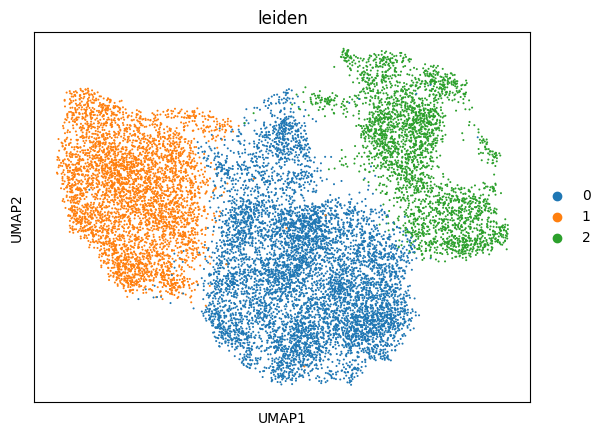

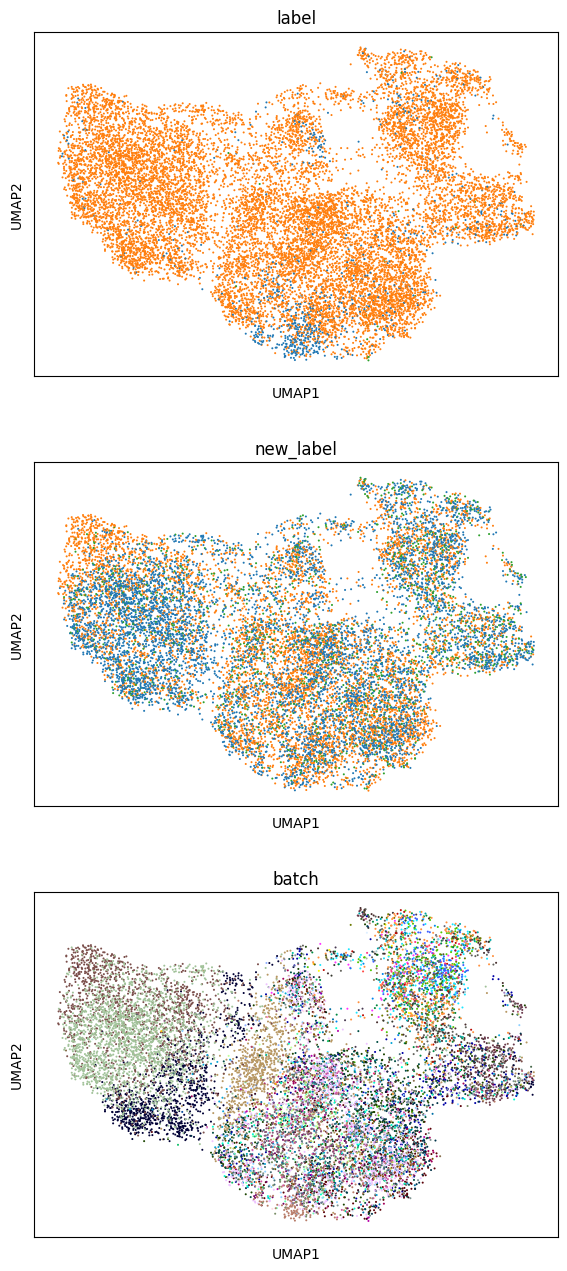

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:19)


In [19]:
sc.tl.leiden(adata, resolution=0.1)
sc.pl.umap(adata, color=["leiden"])
sc.pl.umap(adata, color=["label","new_label","batch"], ncols=1, legend_loc=None)
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', pts=True)


## Leiden clusters, DEG, BP and TF

In [20]:
DEG_0 = pd.DataFrame()

DEG_0["Symbol"] = pd.DataFrame(adata.uns["rank_genes_groups"]["names"])["0"]
DEG_0["pvals_adj"] = pd.DataFrame(adata.uns["rank_genes_groups"]["pvals_adj"])["0"]
DEG_0["logfoldchanges"] = pd.DataFrame(adata.uns["rank_genes_groups"]["logfoldchanges"])["0"]
DEG_0["abs_lfc"] = pd.DataFrame(adata.uns["rank_genes_groups"]["logfoldchanges"])["0"].abs()
DEG_0["scores"] = pd.DataFrame(adata.uns["rank_genes_groups"]["scores"])["0"]
DEG_0 = DEG_0.set_index("Symbol")

DEG_0_pts = pd.DataFrame(adata.uns["rank_genes_groups"]["pts"])["0"]
DEG_0 = pd.merge(DEG_0, DEG_0_pts,left_index=True, right_index=True)
DEG_0 = DEG_0[DEG_0["pvals_adj"] < 0.05]



### Cluster 0

Top up-regulated genes

In [21]:
DEG_0.sort_values("scores", ascending=False).head(10)

pvals_adj  logfoldchanges   abs_lfc     scores         0
RACK1     0.000000e+00        1.529024  1.529024  46.862011  0.867624
CTSW      0.000000e+00        1.714248  1.714248  46.433117  0.834566
ACTB      0.000000e+00        1.352698  1.352698  46.423500  0.984776
FCER1G    0.000000e+00        2.062953  2.062953  44.366268  0.779759
RPS17     0.000000e+00        1.198917  1.198917  42.338680  0.913151
PFN1      0.000000e+00        1.037864  1.037864  40.129578  0.941424
EEF1G     0.000000e+00        1.320802  1.320802  40.103203  0.809482
ATP5F1E   0.000000e+00        1.268447  1.268447  37.858982  0.848485
RPL31    3.750411e-295        0.749093  0.749093  36.888947  0.950123
TMSB10   7.722950e-295        0.695977  0.695977  36.867626  0.982456

up- down- regulated pathways

In [22]:
def GOs(degs):    
    deg_up = degs[degs["logfoldchanges"] > 0].index.to_list()
    # Enricr API
    enr_up = gp.enrichr(deg_up,
                        gene_sets='GO_Biological_Process_2021',
                        outdir=None)

    # trim (go:...)
    enr_up.res2d.Term = enr_up.res2d.Term.str.split(" \(GO").str[0]

    deg_dn = degs[degs["logfoldchanges"] < 0].index.to_list()
    # Enricr API
    enr_dn = gp.enrichr(deg_dn,
                        gene_sets='GO_Biological_Process_2021',
                        outdir=None)

    # trim (go:...)
    enr_dn.res2d.Term = enr_dn.res2d.Term.str.split(" \(GO").str[0]
    
    gp.dotplot(enr_up.res2d, figsize=(2,5), title="Up", cmap = plt.cm.autumn_r)
    plt.show()
    
    gp.dotplot(enr_dn.res2d, figsize=(2,5), title="Down", cmap = plt.cm.winter_r)
    plt.show()

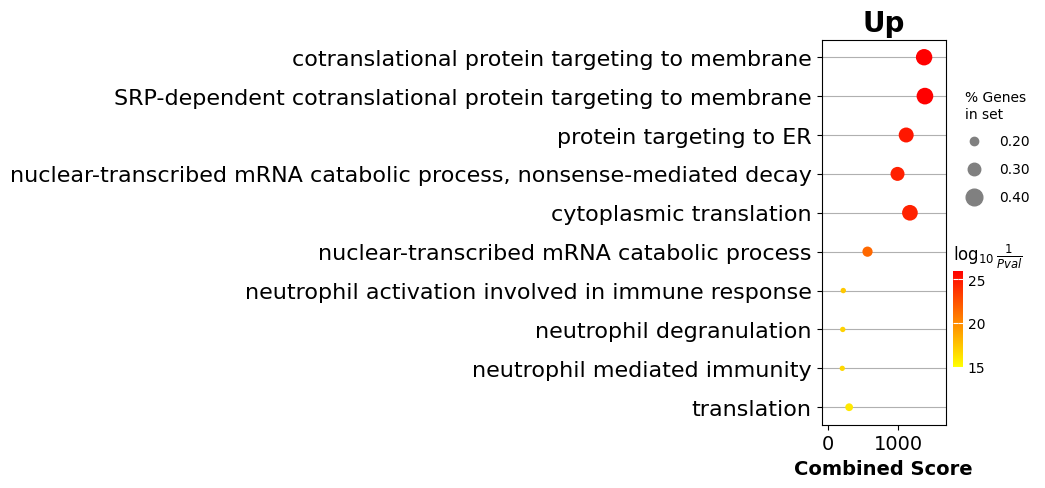

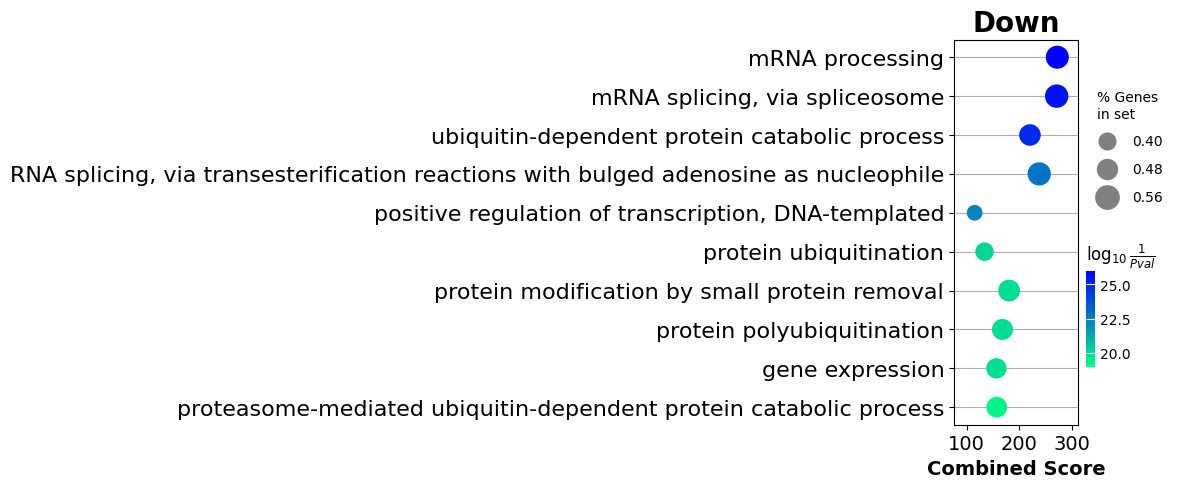

In [23]:
GOs(DEG_0)

Cluster 0 doesn't upregulates specific genes of immune checkpoint receptors related to NK exhaustion. The enriched pathways suggest the enrichment of immune processes

### Cluster 1

Top up-regulated genes

In [24]:
DEG_1 = pd.DataFrame()

DEG_1["Symbol"] = pd.DataFrame(adata.uns["rank_genes_groups"]["names"])["1"]
DEG_1["pvals_adj"] = pd.DataFrame(adata.uns["rank_genes_groups"]["pvals_adj"])["1"]
DEG_1["logfoldchanges"] = pd.DataFrame(adata.uns["rank_genes_groups"]["logfoldchanges"])["1"]
DEG_1["abs_lfc"] = pd.DataFrame(adata.uns["rank_genes_groups"]["logfoldchanges"])["1"].abs()
DEG_1["scores"] = pd.DataFrame(adata.uns["rank_genes_groups"]["scores"])["1"]
DEG_1 = DEG_1.set_index("Symbol")

DEG_1_pts = pd.DataFrame(adata.uns["rank_genes_groups"]["pts"])["1"]
DEG_1 = pd.merge(DEG_1, DEG_1_pts,left_index=True, right_index=True)
DEG_1 = DEG_1[DEG_1["pvals_adj"] < 0.05]
DEG_1.sort_values("scores", ascending=False).head(10)

pvals_adj  logfoldchanges   abs_lfc     scores         1
MTRNR2L12        0.0        5.428245  5.428245  85.957787  0.985603
TPT1             0.0        1.528299  1.528299  73.922653  0.997876
METRNL           0.0        4.278031  4.278031  70.394096  0.842577
CLEC2B           0.0        2.772367  2.772367  64.237289  0.950673
JUND             0.0        3.219890  3.219890  64.022560  0.884116
LINC01578        0.0        3.653805  3.653805  62.212978  0.778145
LDHA             0.0        2.702229  2.702229  61.946045  0.938872
GNAS             0.0        2.926696  2.926696  61.386494  0.874675
HIST1H4C         0.0        3.066264  3.066264  61.276398  0.853198
HLA-A            0.0        1.099264  1.099264  60.495953  0.999056

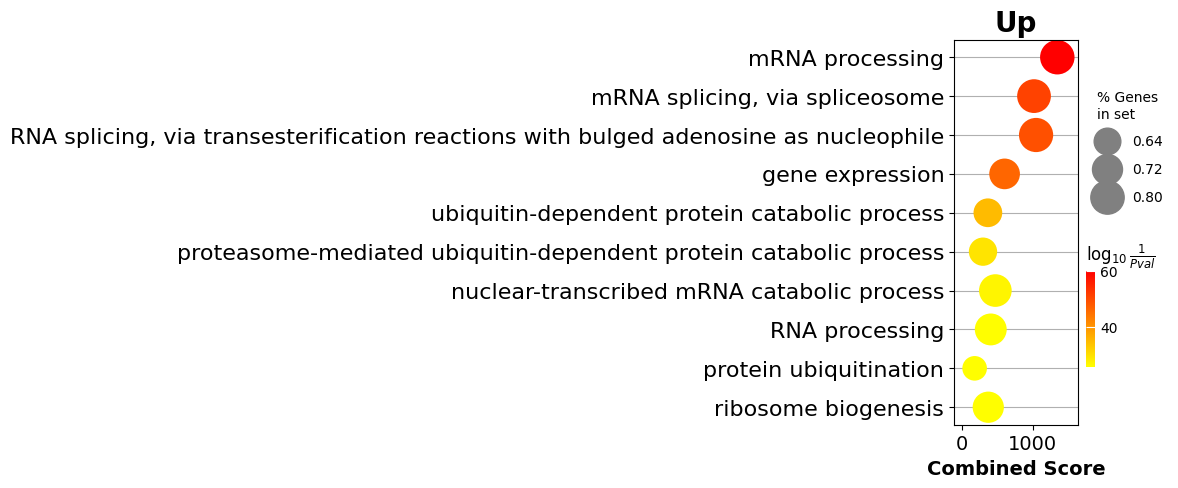

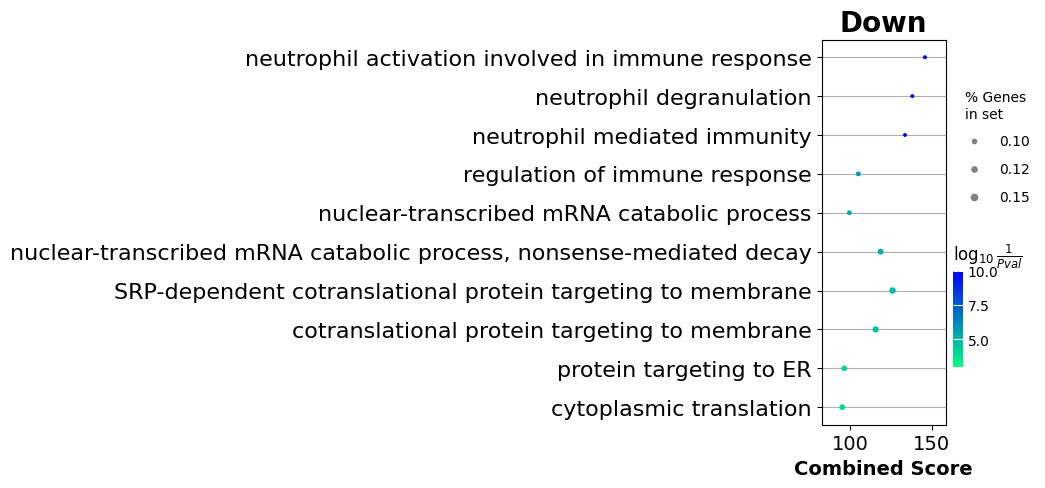

In [25]:
GOs(DEG_1)

Cluster 1 looks the opposite of Cluster 0, down regulation of immune related pathways and active cell transcripion. Could these cell be exhausted? NO division between exhausted and resident NK cells were found in the UMAP

### Cluster 2

Top up-regulated genes

In [26]:
DEG_2 = pd.DataFrame()

DEG_2["Symbol"] = pd.DataFrame(adata.uns["rank_genes_groups"]["names"])["2"]
DEG_2["pvals_adj"] = pd.DataFrame(adata.uns["rank_genes_groups"]["pvals_adj"])["2"]
DEG_2["logfoldchanges"] = pd.DataFrame(adata.uns["rank_genes_groups"]["logfoldchanges"])["2"]
DEG_2["abs_lfc"] = pd.DataFrame(adata.uns["rank_genes_groups"]["logfoldchanges"])["2"].abs()
DEG_2["scores"] = pd.DataFrame(adata.uns["rank_genes_groups"]["scores"])["2"]
DEG_2 = DEG_2.set_index("Symbol")

DEG_2_pts = pd.DataFrame(adata.uns["rank_genes_groups"]["pts"])["2"]
DEG_2 = pd.merge(DEG_2, DEG_2_pts,left_index=True, right_index=True)
DEG_2 = DEG_2[DEG_2["pvals_adj"] < 0.05]
DEG_2.sort_values("scores", ascending=False).head(10)

pvals_adj  logfoldchanges   abs_lfc     scores         2
ATP5E     0.000000e+00        8.162164  8.162164  49.703804  0.602961
GNB2L1    0.000000e+00        7.683477  7.683477  47.699005  0.580579
ATP5L     0.000000e+00        7.687450  7.687450  37.945911  0.460399
ATP5G2   9.237418e-304        8.493318  8.493318  37.404438  0.452135
RPL7     5.495666e-272        0.595198  0.595198  35.389103  0.892218
RARRES3  3.587023e-260        7.555178  7.555178  34.610233  0.420110
C14orf2  2.127094e-249        7.573108  7.573108  33.884426  0.411157
SEPT7    3.287299e-247        8.204267  8.204267  33.734791  0.408058
TCEB2    1.044718e-233        7.623756  7.623756  32.798454  0.397727
RPL34    8.169294e-222        0.370979  0.370979  31.949730  0.949036

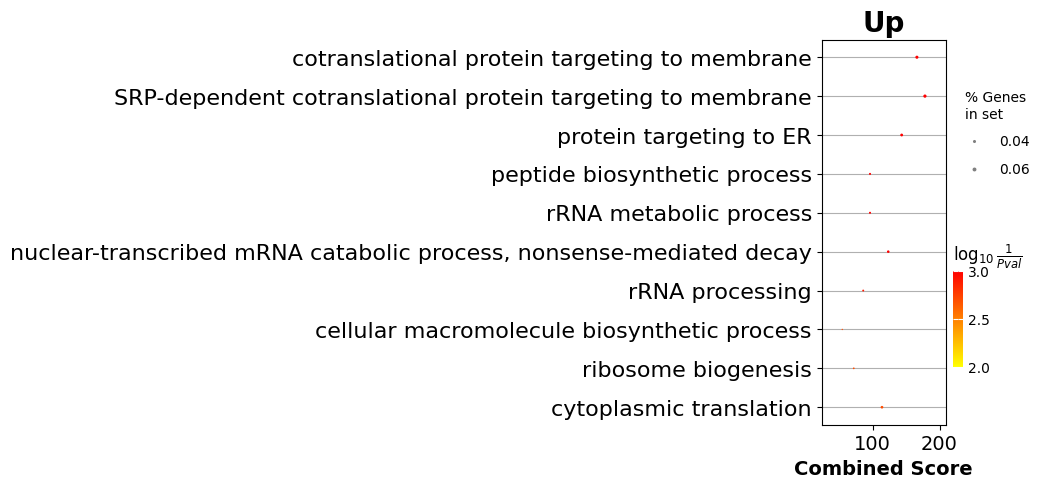

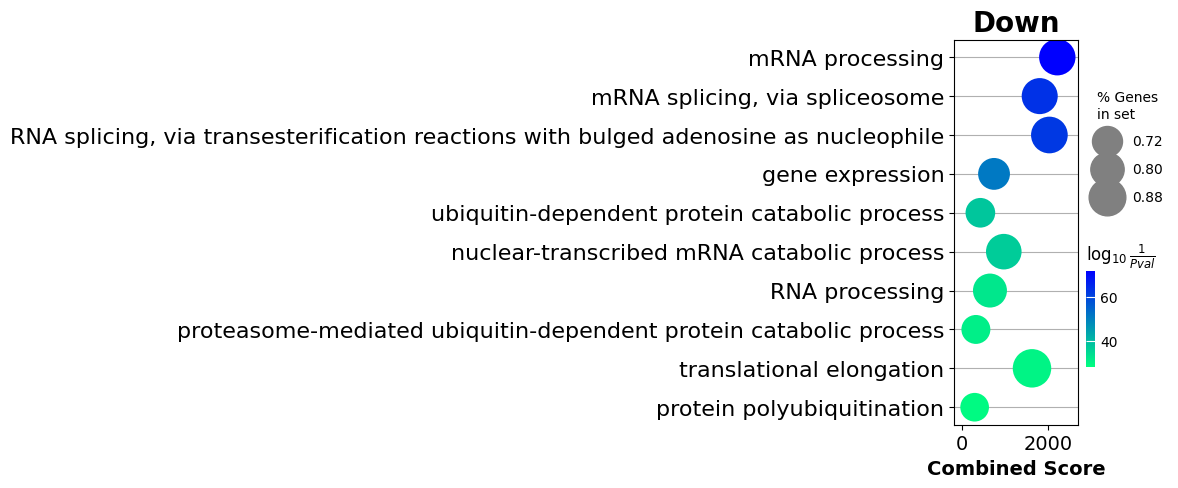

In [27]:
GOs(DEG_2)

Cluster 2 upregulated more pathways related to protein localization and protein translation, it looks like the middle point between the first 2 clusters (as in the umap).

### TFs for clusters

#### Regulon specificity scores (RSS) across clusters

In [28]:
adata.obs["leiden"]
cellAnnot = pd.concat([cellAnnot, adata.obs["leiden"]],axis=1)

In [29]:
df_motifs = load_motifs('Results/reg_mm.csv')

In [30]:
# Z-score area under the curve for selected regulons
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)



In [31]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f


def TF_activity(label, n):
    rss_cellType = regulon_specificity_scores( auc_mtx, cellAnnot[label] )
    print(rss_cellType)
    
    cats = sorted(list(set(cellAnnot[label])))

    fig = plt.figure(figsize=(15, 8))
    for c,num in zip(cats, range(1,len(cats)+1)):
        x=rss_cellType.T[c]
        ax = fig.add_subplot(1,3,num)
        plot_rss(rss_cellType, c, top_n=n, max_n=None, ax=ax)
        ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
        for t in ax.texts:
            t.set_fontsize(12)
        ax.set_ylabel('')
        ax.set_xlabel('')
        adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )

    fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
    fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
    plt.tight_layout()
    plt.rcParams.update({
        'figure.autolayout': True,
            'figure.titlesize': 'large' ,
            'axes.labelsize': 'medium',
            'axes.titlesize':'large',
            'xtick.labelsize':'medium',
            'ytick.labelsize':'medium'
            })
    #plt.savefig("test_cell-state-RSS-top5.pdf", dpi=600, bbox_inches = "tight")
    plt.show()
    
    # top regulons for each cell type
    topreg = []
    for i,c in enumerate(cats):
        topreg.extend(
            list(rss_cellType.T[c].sort_values(ascending=False)[:n].index)
        )
    topreg = list(set(topreg))

    colors = sns.color_palette('bright',n_colors=len(cats) )
    colorsd = dict( zip( cats, colors ))
    colormap = [ colorsd[x] for x in cellAnnot[label] ]

    sns.set()
    sns.set(font_scale=0.8)
    fig = palplot( colors, cats, size=2.0)

    sns.set(font_scale=1.2)
    g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
        yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
        cmap="YlGnBu", figsize=(21,16) )
    g.cax.set_visible(True)
    g.ax_heatmap.set_ylabel('')
    g.ax_heatmap.set_xlabel('')

    means = round(rss_cellType.T.mean(),3)
    means = means.rename("mean")
    sd = round(rss_cellType.T.std(),3)
    sd = sd.rename("StDev")
    ratio = round(adata.obs[label].value_counts()/adata.n_obs,3)
    ratio = ratio.rename("Ratio")
    specs = pd.concat([means,sd,ratio],axis=1)
    print(specs)
    
    
    return rss_cellType



   ARID3A_(+)  ARNTL_(+)  ATF1_(+)  ATF2_(+)  ATF4_(+)  ATF6_(+)  BACH1_(+)  \
2    0.394791   0.318480  0.357749  0.378298  0.353037  0.296966   0.348593   
0    0.460208   0.475935  0.538349  0.478939  0.525389  0.438195   0.501305   
1    0.337867   0.401619  0.379810  0.355069  0.410612  0.331232   0.438827   

   BACH2_(+)  BCL11B_(+)  BCL6_(+)  ...  ZNF576_(+)  ZNF580_(+)  ZNF587_(+)  \
2   0.342087    0.336559  0.354982  ...    0.397024    0.375913    0.247703   
0   0.470368    0.497121  0.356044  ...    0.507455    0.533577    0.319101   
1   0.401026    0.455151  0.389804  ...    0.319025    0.387931    0.235772   

   ZNF600_(+)  ZNF655_(+)  ZNF669_(+)  ZNF680_(+)  ZNF708_(+)  ZNF770_(+)  \
2    0.331257    0.272575    0.399379    0.517156    0.361058    0.339316   
0    0.418928    0.351432    0.525137    0.352200    0.220787    0.266013   
1    0.353573    0.250323    0.324060    0.280323    0.227524    0.216985   

   ZSCAN26_(+)  
2     0.280710  
0     0.393594  
1     

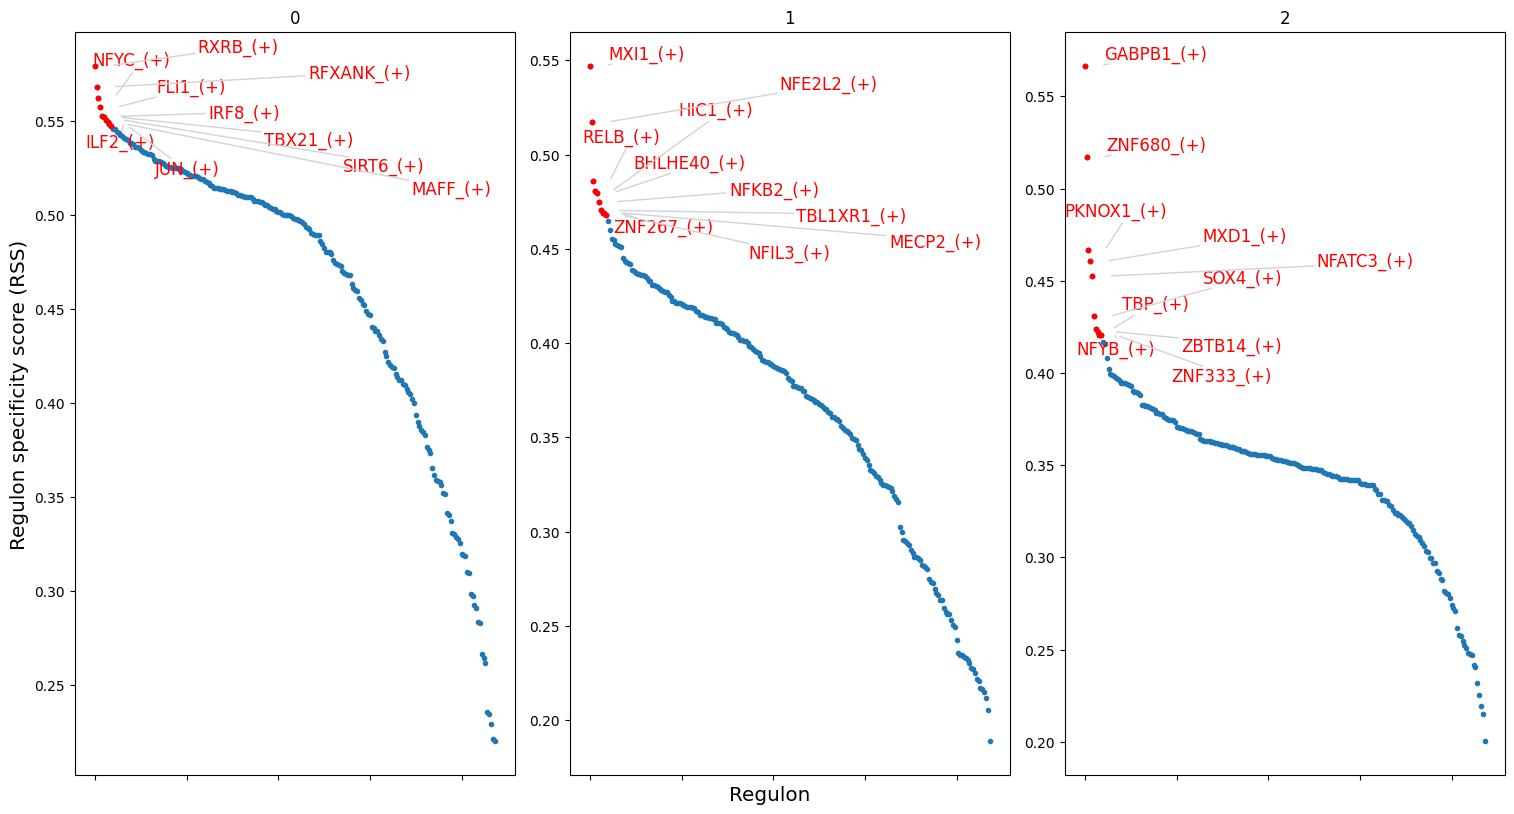

    mean  StDev  Ratio
2  0.347  0.048  0.207
0  0.463  0.082  0.491
1  0.365  0.072  0.302


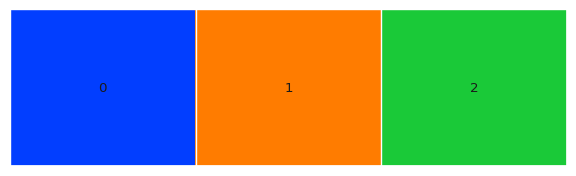

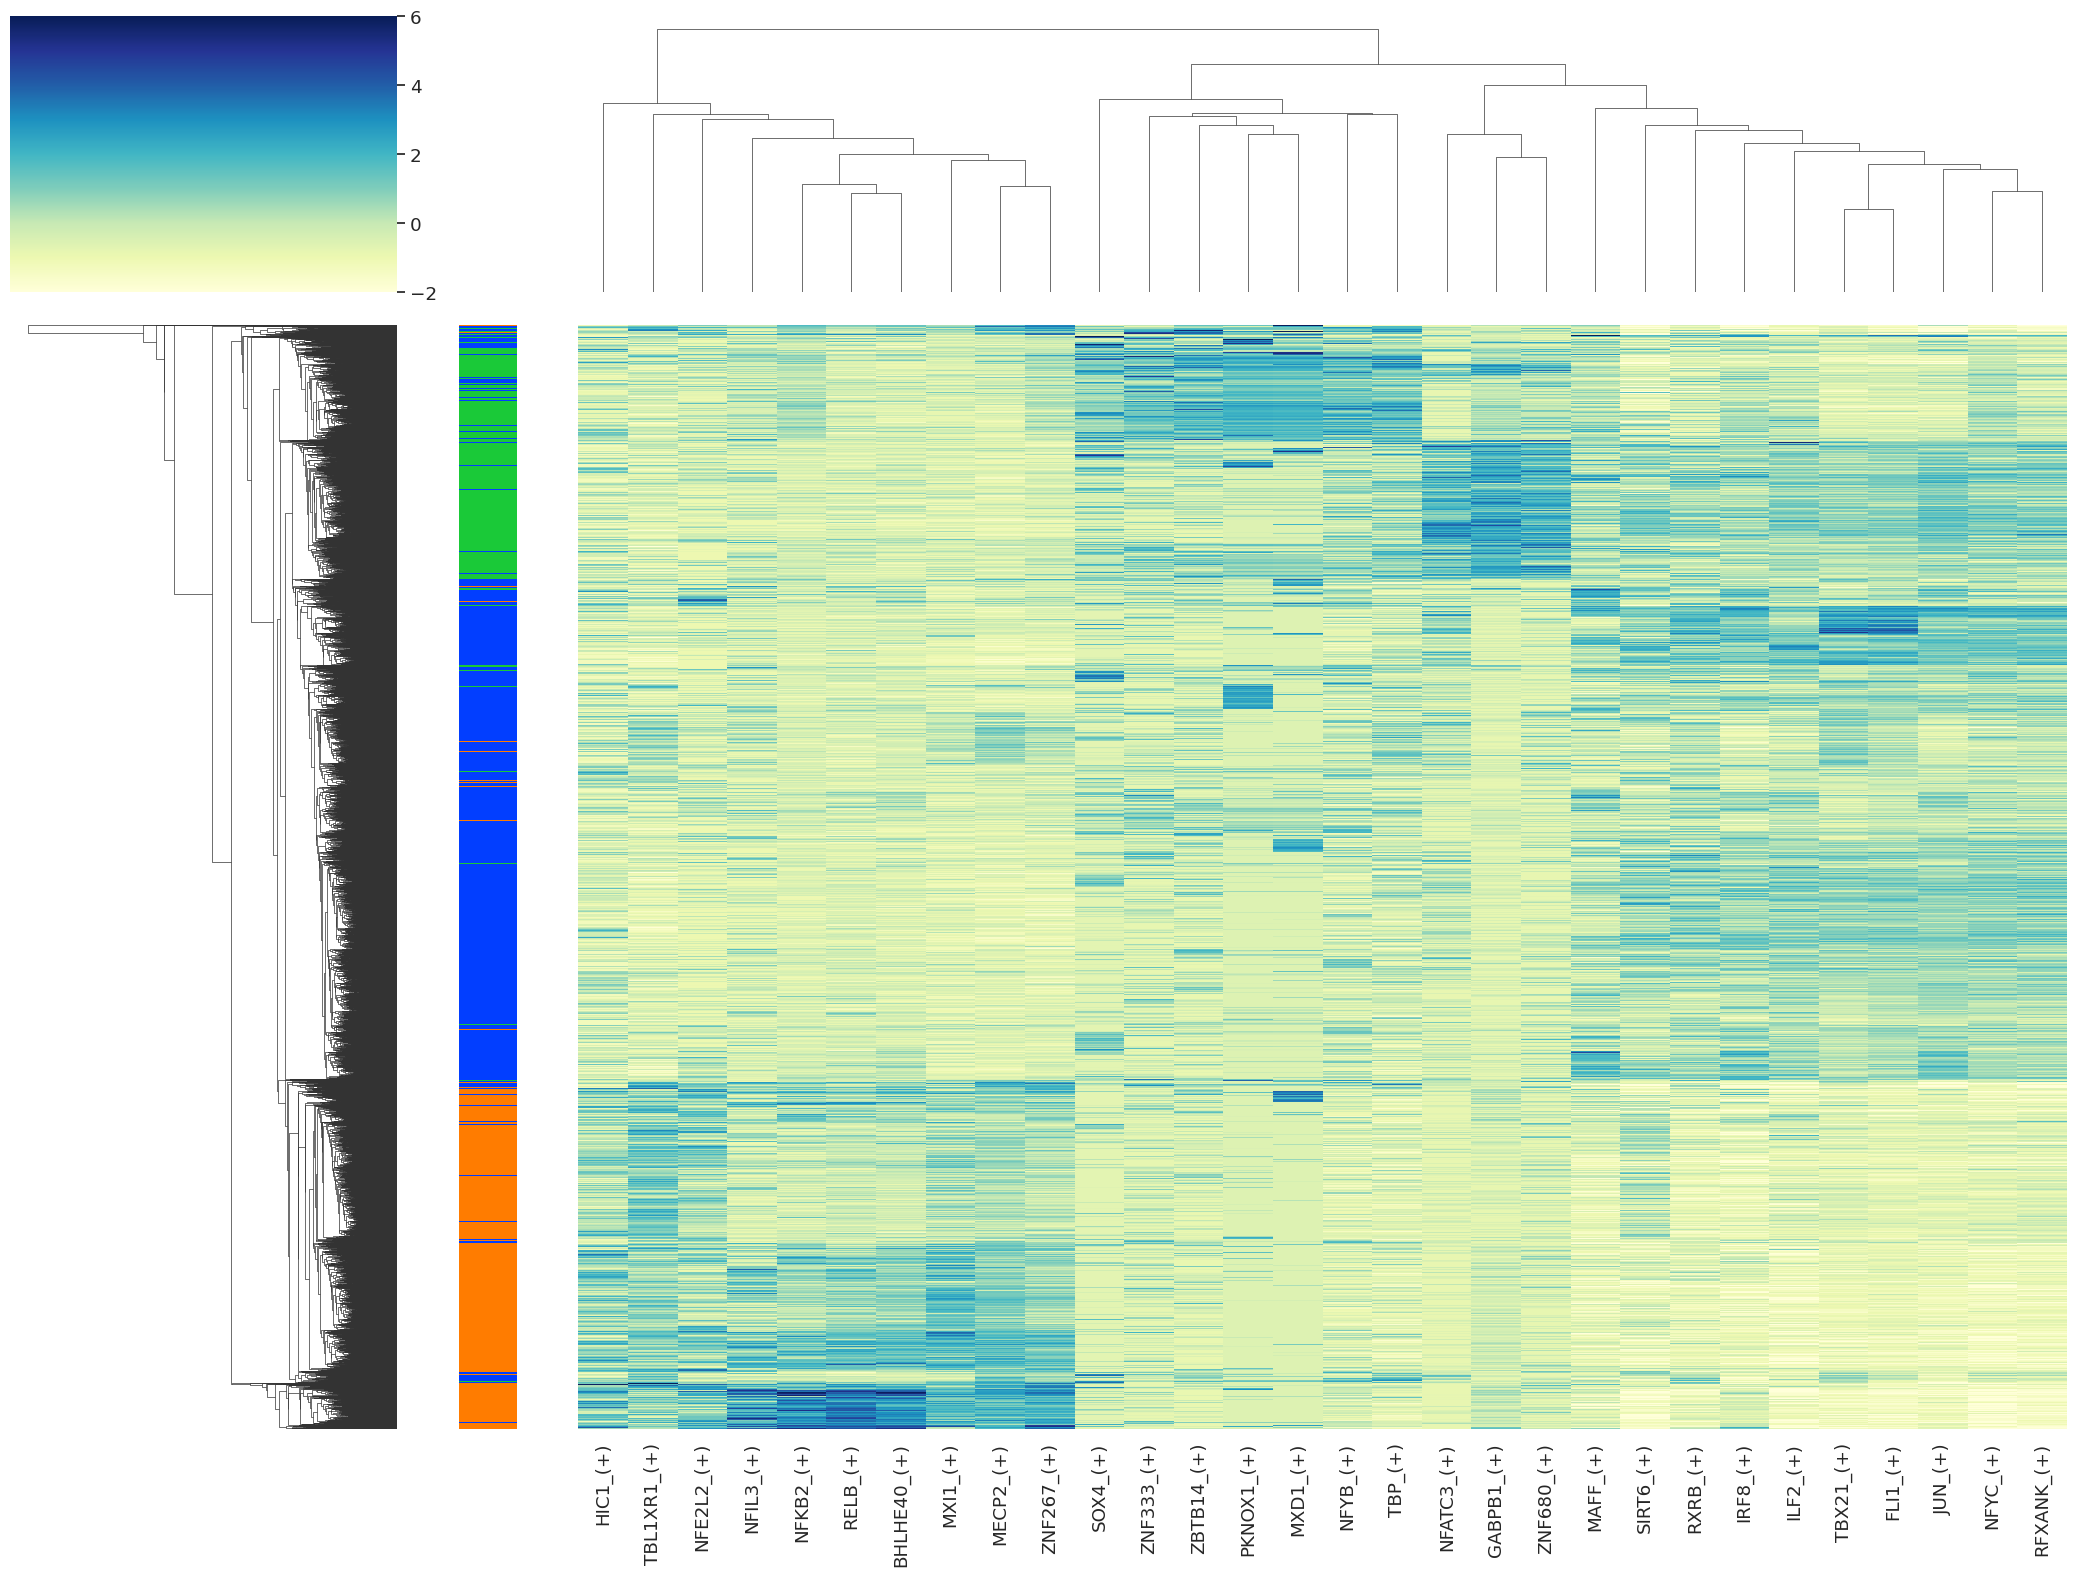

In [32]:
rss_cellType = TF_activity("leiden", 10)

In [35]:
binary_mtx, auc_thresholds = binarize( auc_mtx, num_workers=25 )
binary_mtx.head()

ARID3A_(+)  ARNTL_(+)  ATF1_(+)  \
MGUS_CD138nCD45p_2_ACTGCTCGTCTAGGTT-1           0          0         0   
MGUS_CD138nCD45p_2_CACATTTTCATAACCG-1           0          0         0   
MGUS_CD138nCD45p_2_CCAATCCGTGCAGACA-1           0          0         0   
MGUS_CD138nCD45p_2_GCATGTACAATCGAAA-1           1          0         0   
MGUS_CD138nCD45p_2_GCGAGAATCTGCGTAA-1           0          0         0   

                                       ATF2_(+)  ATF4_(+)  ATF6_(+)  \
MGUS_CD138nCD45p_2_ACTGCTCGTCTAGGTT-1         1         0         0   
MGUS_CD138nCD45p_2_CACATTTTCATAACCG-1         0         0         1   
MGUS_CD138nCD45p_2_CCAATCCGTGCAGACA-1         0         0         0   
MGUS_CD138nCD45p_2_GCATGTACAATCGAAA-1         0         0         0   
MGUS_CD138nCD45p_2_GCGAGAATCTGCGTAA-1         0         0         1   

                                       BACH1_(+)  BACH2_(+)  BCL11B_(+)  \
MGUS_CD138nCD45p_2_ACTGCTCGTCTAGGTT-1          0          0           0   
MGUS_CD138nCD45p_2_CACATTTTCATAACCG-1          0          0           0   
MGUS_CD138nCD45p_2_CCAATCCGTGCAGACA-1          0          1           0   
MGUS_CD138nCD45p_2_GCATGTACAATCGAAA-1          0          0           0   
MGUS_CD138nCD45p_2_GCGAGAATCTGCGTAA-1          0          0           0   

                                       BCL6_(+)  ...  ZNF576_(+)  ZNF580_(+)  \
MGUS_CD138nCD45p_2_ACTGCTCGTCTAGGTT-1         1  ...           1           0   
MGUS_CD138nCD45p_2_CACATTTTCATAACCG-1         0  ...           0           1   
MGUS_CD138nCD45p_2_CCAATCCGTGCAGACA-1         1  ...           0           0   
MGUS_CD138nCD45p_2_GCATGTACAATCGAAA-1         1  ...           1           0   
MGUS_CD138nCD45p_2_GCGAGAATCTGCGTAA-1         1  ...           0           0   

                                       ZNF587_(+)  ZNF600_(+)  ZNF655_(+)  \
MGUS_CD138nCD45p_2_ACTGCTCGTCTAGGTT-1           1           1           0   
MGUS_CD138nCD45p_2_CACATTTTCATAACCG-1           0           1           0   
MGUS_CD138nCD45p_2_CCAATCCGTGCAGACA-1           0           0           0   
MGUS_CD138nCD45p_2_GCATGTACAATCGAAA-1           0           1           0   
MGUS_CD138nCD45p_2_GCGAGAATCTGCGTAA-1           0           0           0   

                                       ZNF669_(+)  ZNF680_(+)  ZNF708_(+)  \
MGUS_CD138nCD45p_2_ACTGCTCGTCTAGGTT-1           0           1           0   
MGUS_CD138nCD45p_2_CACATTTTCATAACCG-1           0           0           0   
MGUS_CD138nCD45p_2_CCAATCCGTGCAGACA-1           0           1           0   
MGUS_CD138nCD45p_2_GCATGTACAATCGAAA-1           0           1           0   
MGUS_CD138nCD45p_2_GCGAGAATCTGCGTAA-1           0           1           0   

                                       ZNF770_(+)  ZSCAN26_(+)  
MGUS_CD138nCD45p_2_ACTGCTCGTCTAGGTT-1           0            0  
MGUS_CD138nCD45p_2_CACATTTTCATAACCG-1           0            0  
MGUS_CD138nCD45p_2_CCAATCCGTGCAGACA-1           0            0  
MGUS_CD138nCD45p_2_GCATGTACAATCGAAA-1           0            0  
MGUS_CD138nCD45p_2_GCGAGAATCTGCGTAA-1           0            1  

[5 rows x 219 columns]

In [36]:
def AUC_plot(rss_cellType):
    # top regulons for each cell type
    topreg = []
    for i,c in enumerate(rss_cellType.T):
        topreg = rss_cellType.loc[c].sort_values(ascending=False).index.to_list()[:5]
        topreg = list(set(topreg))
        
        fig, axs = plt.subplots(1, 5, figsize=(12, 4), dpi=150, sharey=False)
        for i,ax in enumerate(axs):
            sns.distplot(auc_mtx[ topreg[i] ], ax=ax, norm_hist=True, bins=100)
            ax.plot( [ auc_thresholds[ topreg[i] ] ]*2, ax.get_ylim(), 'r:')
            ax.title.set_text( topreg[i] )
            ax.set_xlabel('')

        fig.suptitle(c)
        fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='large')
        fig.text(0.5, -0.01, 'AUC', ha='center', va='center', rotation='horizontal', size='large')

        fig.tight_layout()

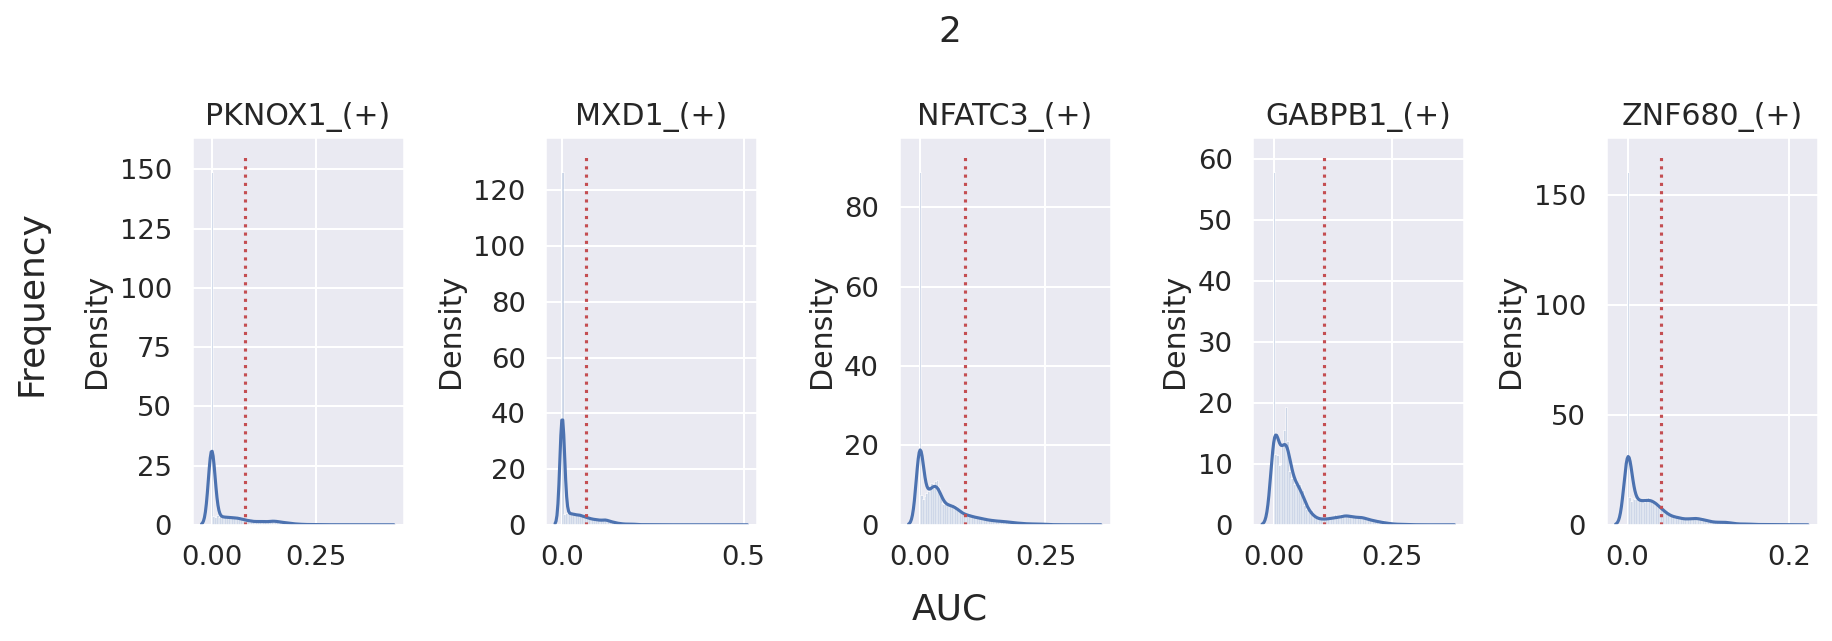

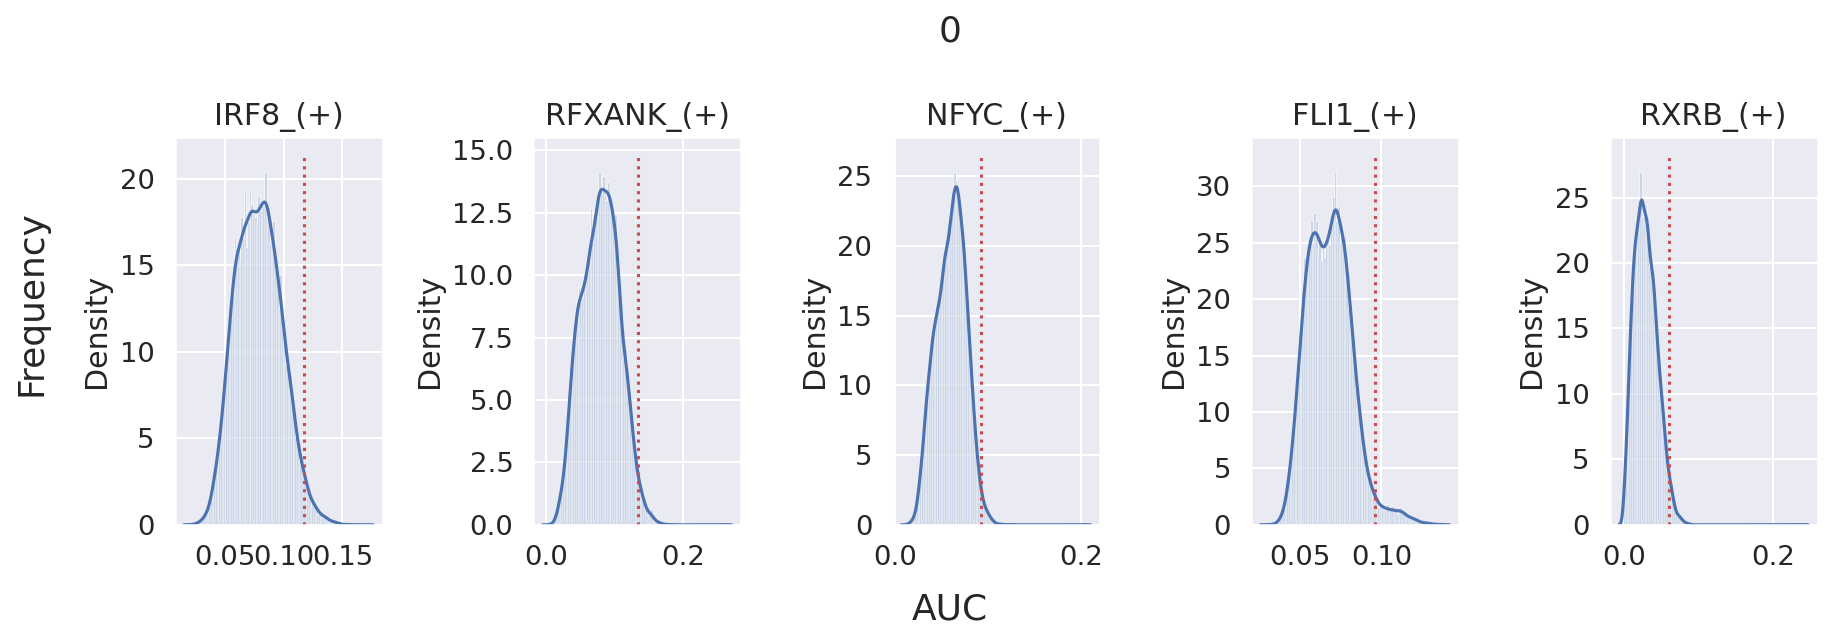

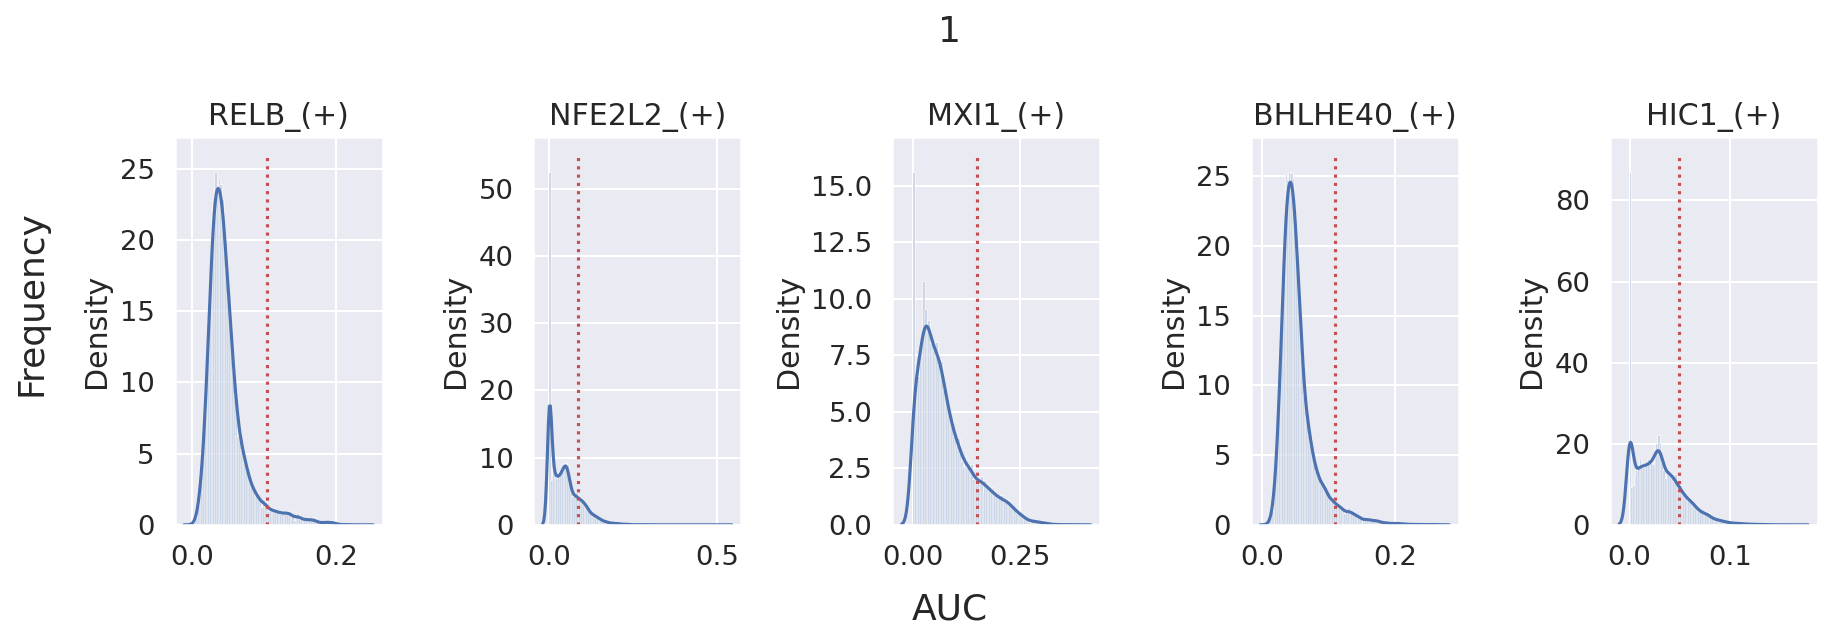

In [37]:
AUC_plot(rss_cellType)

The specificity score for the clusters reach ~ 0.55, not super high but differently from previoous analyses the scores decrease meaningfully. Also the scores are in the rane of other examples provided by the group who developed scenic [example](http://htmlpreview.github.io/?https://github.com/aertslab/SCENICprotocol/blob/master/notebooks/PBMC10k_downstream-analysis.html). The heatmap also roughly cluster the clusters together. The AUC doesn't look like high, probably these specific regulons aren't highly expressed along the clusters, check:

Expression TFs cluster 2 along the umap


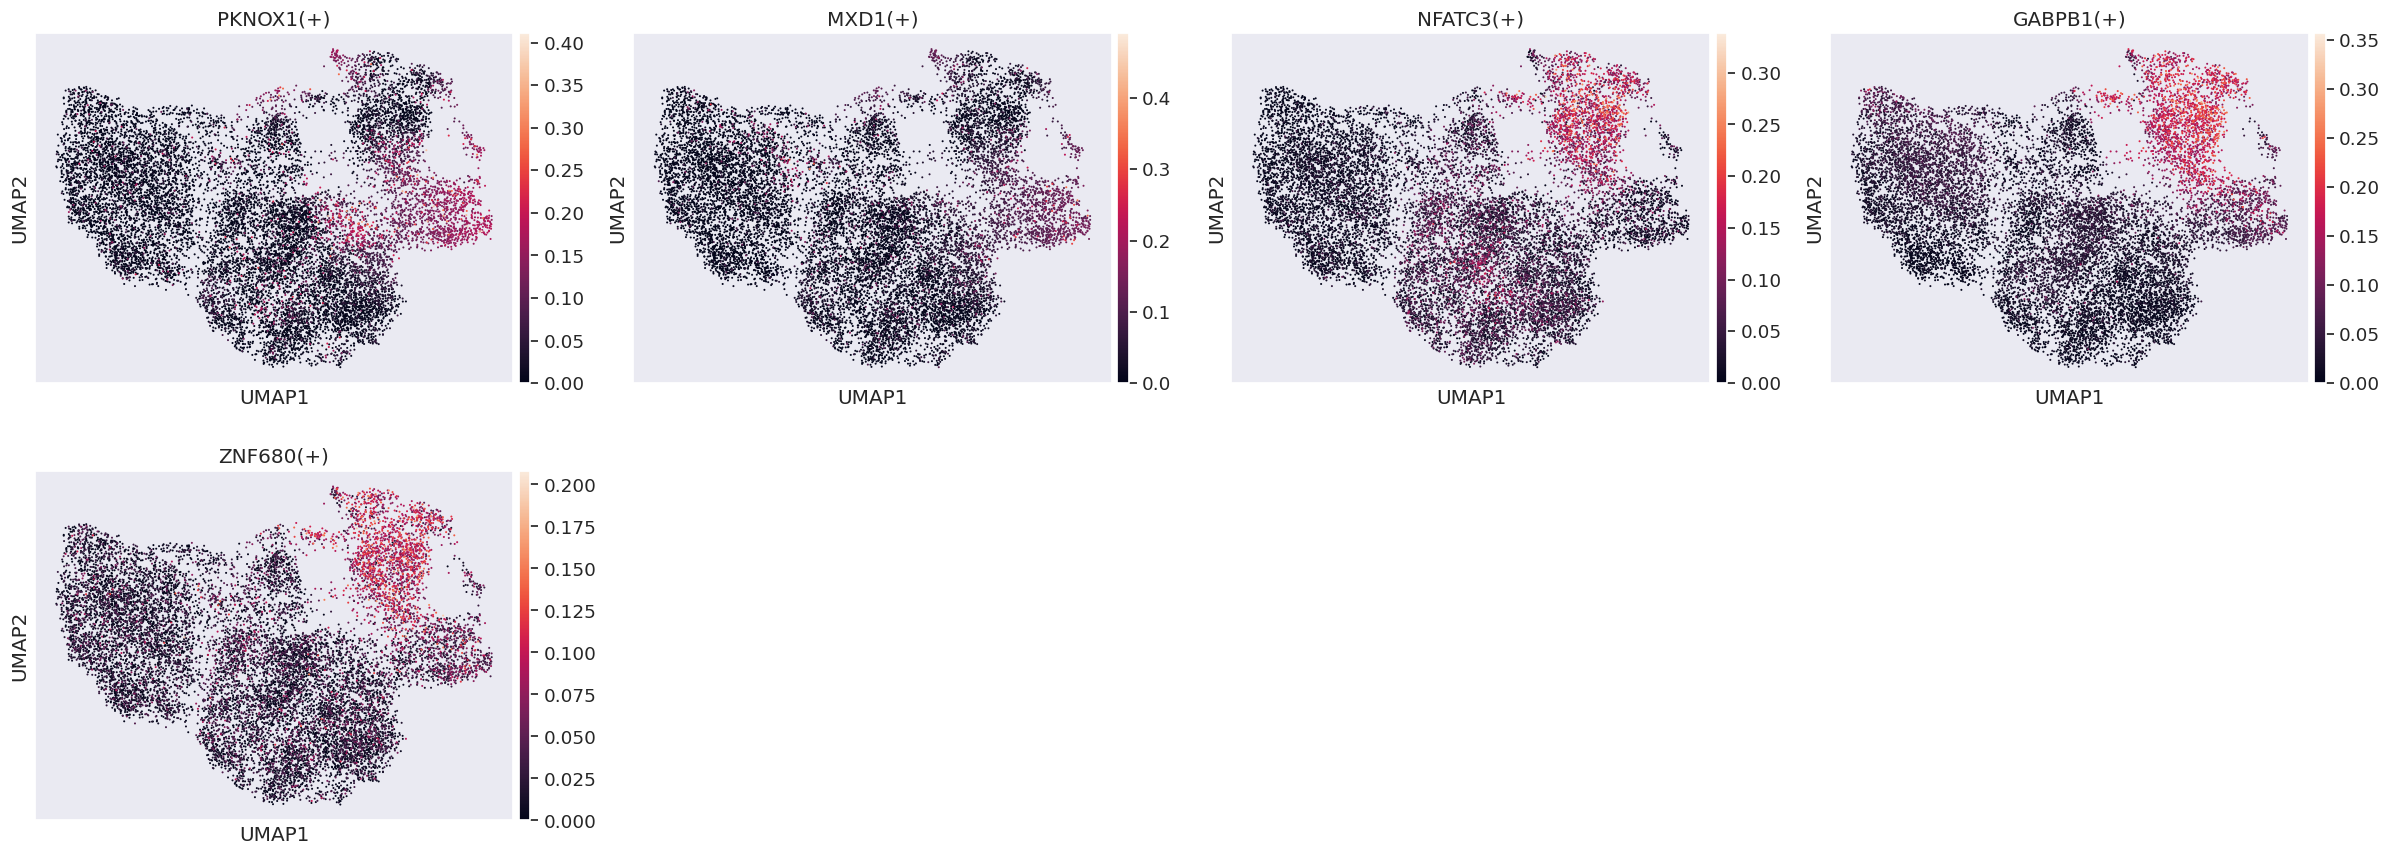

Expression TFs cluster 0 along the umap


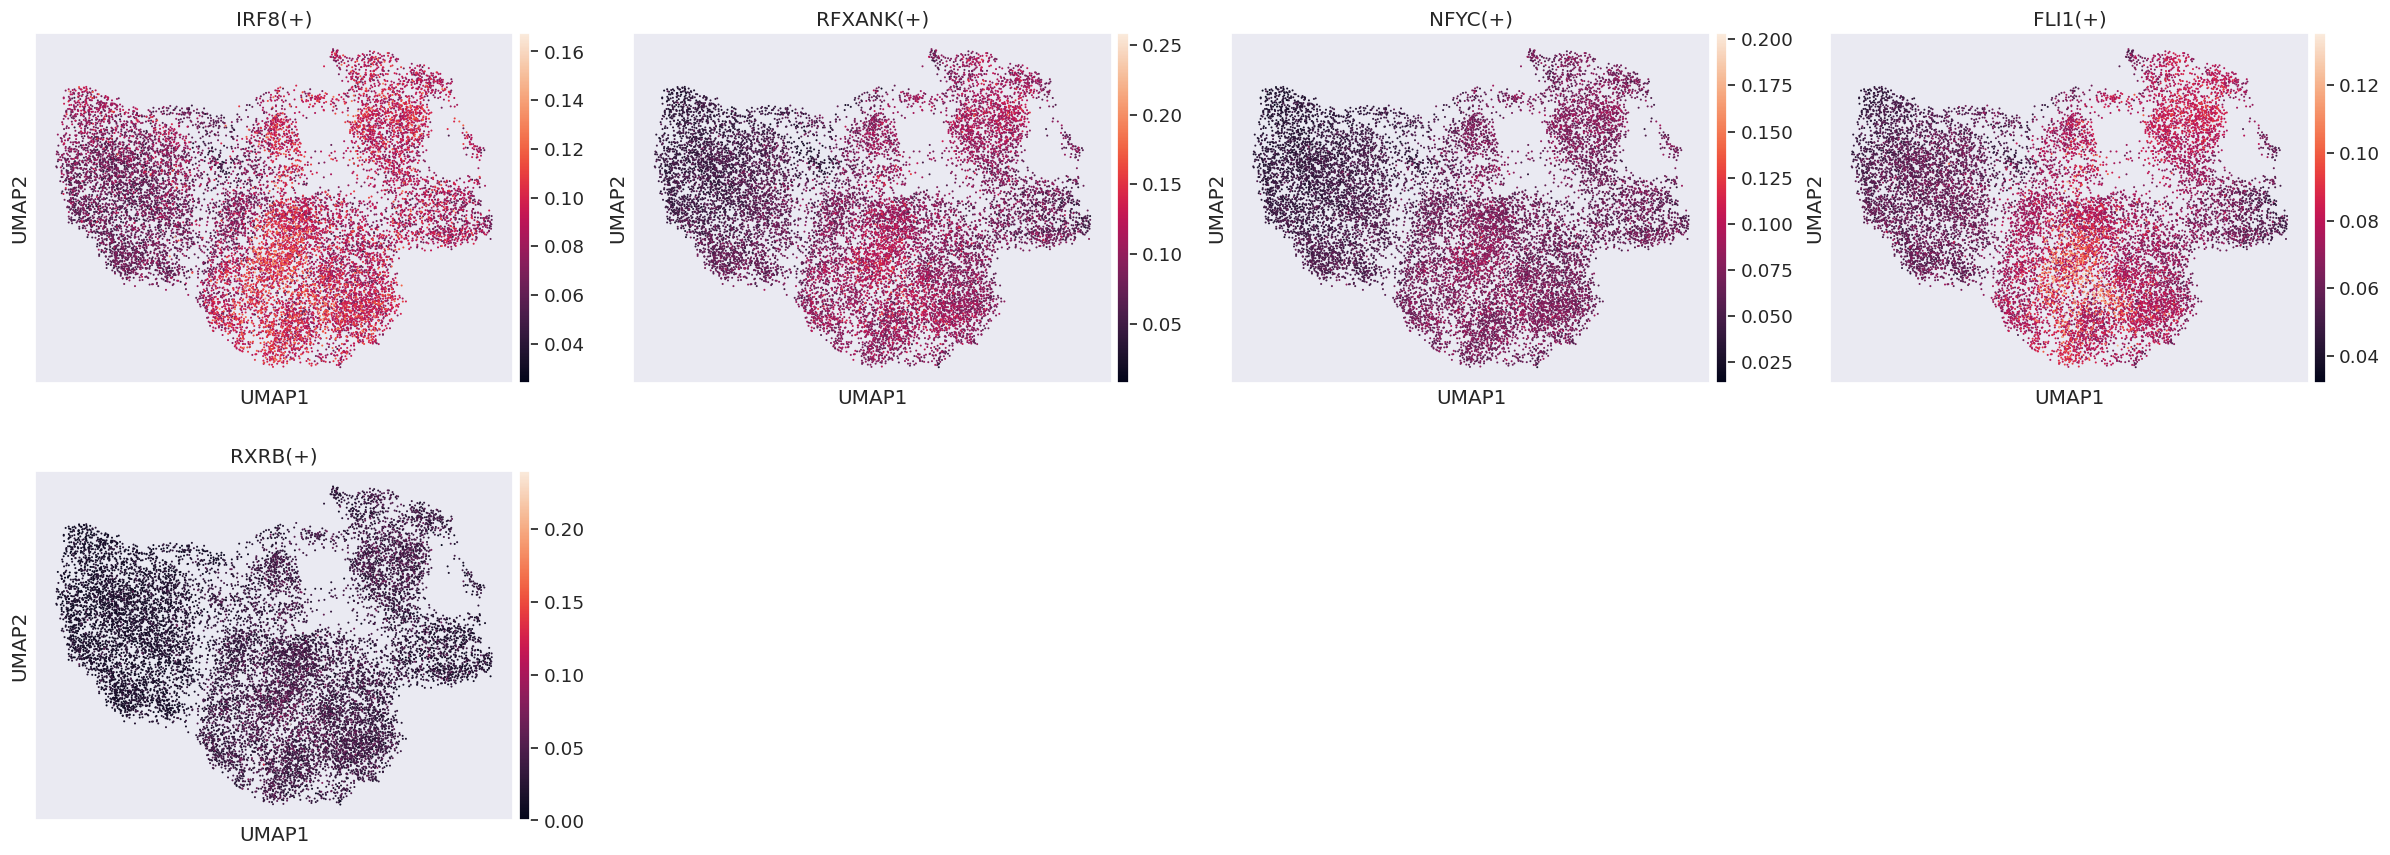

Expression TFs cluster 1 along the umap


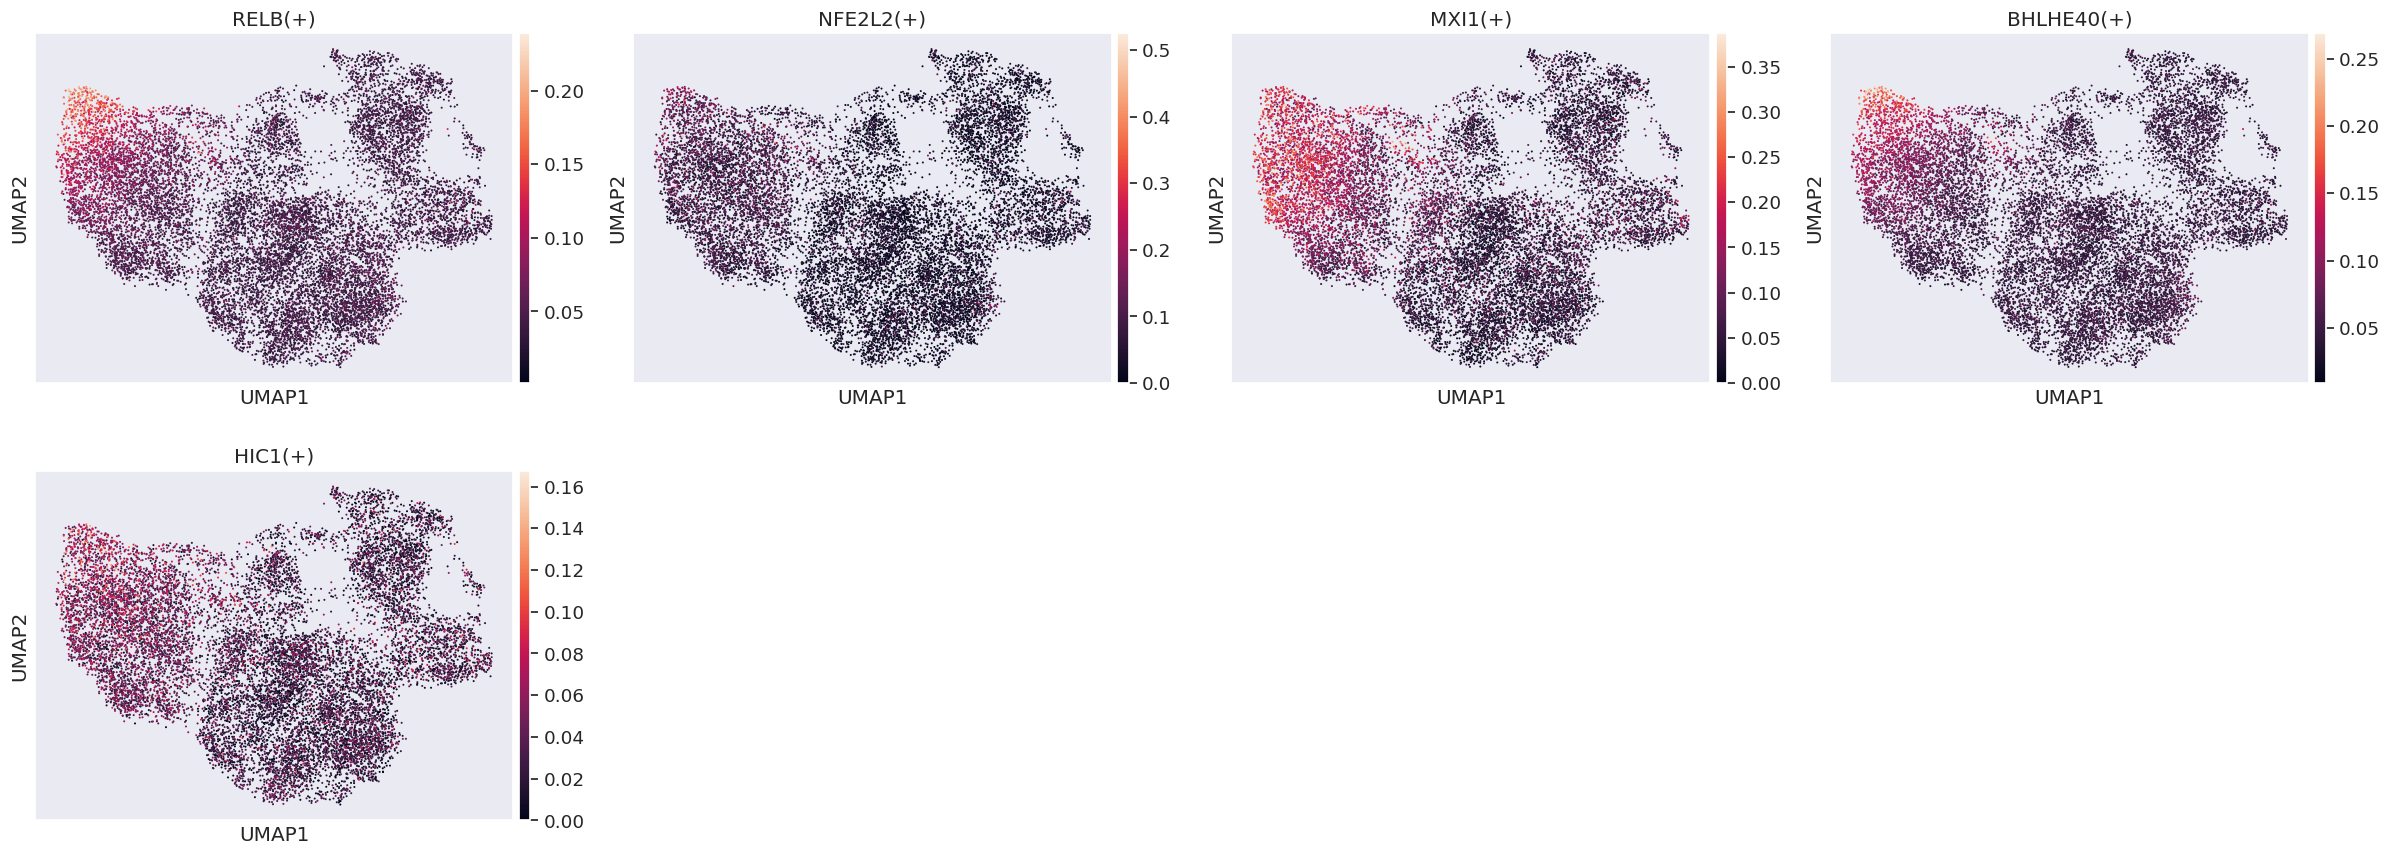

In [38]:
for i,c in enumerate(rss_cellType.T):

    topreg = rss_cellType.loc[c].sort_values(ascending=False).index.to_list()[:5]
    topreg = list(set(topreg))
    print(f"Expression TFs cluster {c} along the umap")
    for f in range(len(topreg)):
        topreg[f] = topreg[f].replace("_","")
    
    sc.pl.umap(adata_umap, color =topreg)

The TFs are indeed expressed in the different clusters, also looking at the TF in the cluster 2 maybe a more granular clustering would be useful. Now I proceed to save the TFs and regulons in a json file to export them:

In [39]:
def export_regulons(rss_cellType, output,n):
    regulons_dict = {}
    for i,c in enumerate(rss_cellType.T):
        regulons_dict[c] = {}

        topreg = rss_cellType.loc[c].sort_values(ascending=False).index.to_list()[:n]
        topreg = list(set(topreg))
        for f in range(len(topreg)):
            regulons_dict[c][topreg[f]] = regulons[topreg[f]]
            
    with open(output + "json", "w") as outfile:
         json.dump(regulons_dict, outfile)
    
    regulons_df = pd.DataFrame.from_dict(regulons_dict, orient="index").stack().to_frame()
    regulons_df = regulons_df.reset_index()
    regulons_df.columns = ["group", "TF","Regulon"]
    regulons_df.to_csv(output + ".csv", index=False)


In [40]:
export_regulons(rss_cellType, "Results/clusters_TFs",10)


In [41]:
## Print top enriched TFs and motifs

In [42]:
# # helper functions (not yet integrated into pySCENIC):

# from pyscenic.utils import load_motifs
# import operator as op
# from IPython.display import HTML, display

# BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
# COLUMN_NAME_LOGO = "MotifLogo"
# COLUMN_NAME_MOTIF_ID = "MotifID"
# COLUMN_NAME_TARGETS = "TargetGenes"

# def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
#     """
#     :param df:
#     :param base_url:
#     """
#     # Make sure the original dataframe is not altered.
#     df = df.copy()
    
#     # Add column with URLs to sequence logo.
#     def create_url(motif_id):
#         return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
#     df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
#     # Truncate TargetGenes.
#     def truncate(col_val):
#         return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
#     df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
#     MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
#     pd.set_option('display.max_colwidth', 200)
#     display(HTML(df.head().to_html(escape=False)))
#     pd.set_option('display.max_colwidth', MAX_COL_WIDTH)


### TFs for cell types

#### Regulon specificity scores (RSS) across cell types

In [43]:
# sorted_tfs = df_motifs.sort_values([("Enrichment","NES")], ascending=False).index.get_level_values('TF').to_list()

# def get_unique_N(iterable, N):
#     """Yields (in order) the first N unique elements of iterable. 
#     Might yield less if data too short."""
#     seen = set()
#     for e in iterable:
#         if e in seen:
#             continue
#         seen.add(e)
#         if len(seen) == N:
#             seen = list(seen)
#             return seen

# top_five = get_unique_N(sorted_tfs, 5)
# top_five


In [44]:
# #display_logos(df_motifs.head())
# display_logos( df_motifs_sel.sort_values([('Enrichment','NES')], ascending=False))

                          ARID3A_(+)  ARNTL_(+)  ATF1_(+)  ATF2_(+)  ATF4_(+)  \
CD56dimCD16+ NK cells       0.657145   0.685951  0.799759  0.695849  0.819322   
CD56brightCD16- NK cells    0.236673   0.223587  0.237522  0.229460  0.244489   
NK cell progenitors         0.170845   0.169895  0.170256  0.170300  0.171402   

                          ATF6_(+)  BACH1_(+)  BACH2_(+)  BCL11B_(+)  \
CD56dimCD16+ NK cells     0.531031   0.824237   0.683304    0.834986   
CD56brightCD16- NK cells  0.234234   0.236023   0.259407    0.226584   
NK cell progenitors       0.171323   0.170173   0.169722    0.169580   

                          BCL6_(+)  ...  ZNF576_(+)  ZNF580_(+)  ZNF587_(+)  \
CD56dimCD16+ NK cells     0.554315  ...    0.699939    0.830660    0.331016   
CD56brightCD16- NK cells  0.218650  ...    0.231419    0.245246    0.204168   
NK cell progenitors       0.169995  ...    0.170470    0.171334    0.170350   

                          ZNF600_(+)  ZNF655_(+)  ZNF669_(+)  ZNF680_

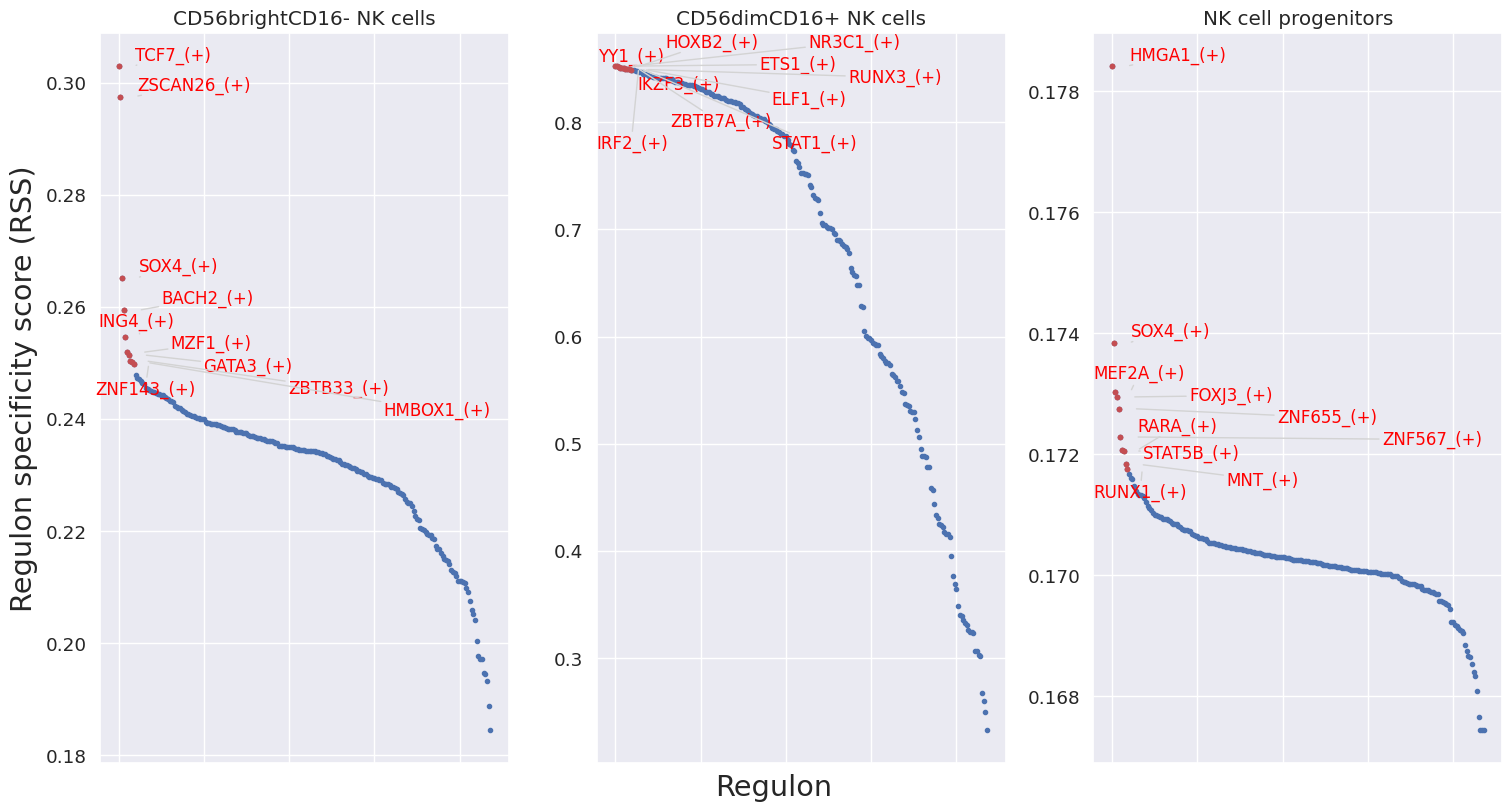

                           mean  StDev  Ratio
CD56dimCD16+ NK cells     0.682  0.175  0.938
CD56brightCD16- NK cells  0.232  0.014  0.060
NK cell progenitors       0.170  0.001  0.001


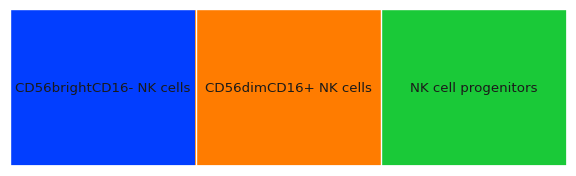

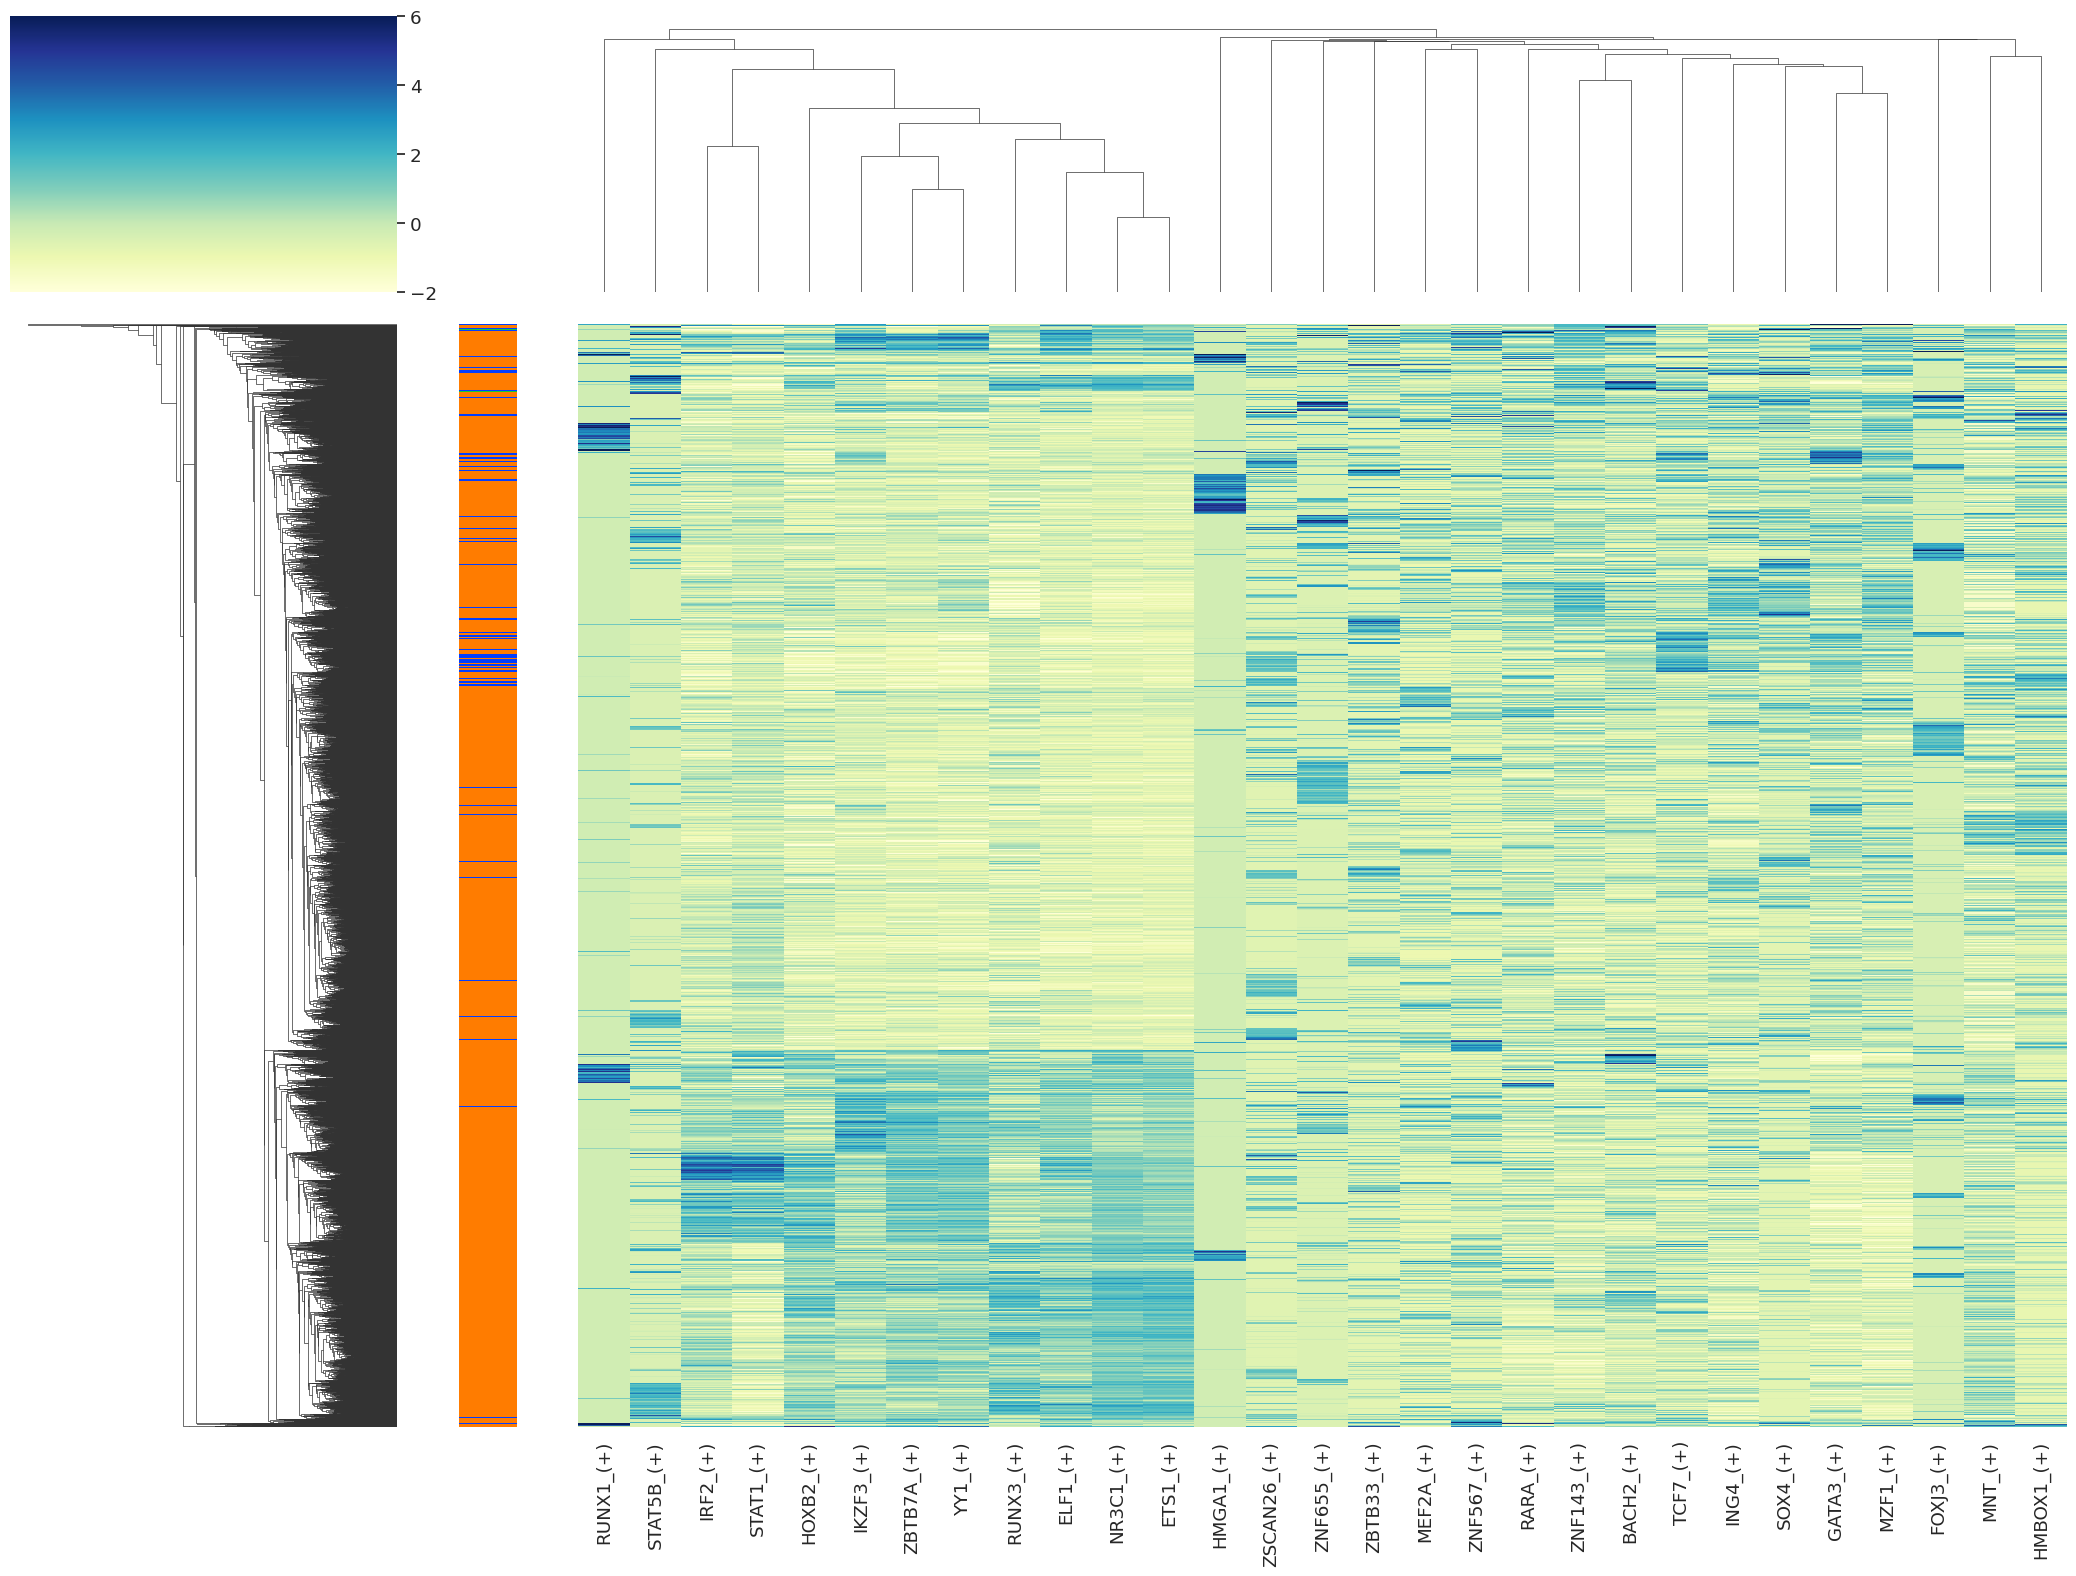

In [46]:
rss_cellType = TF_activity("label",10)

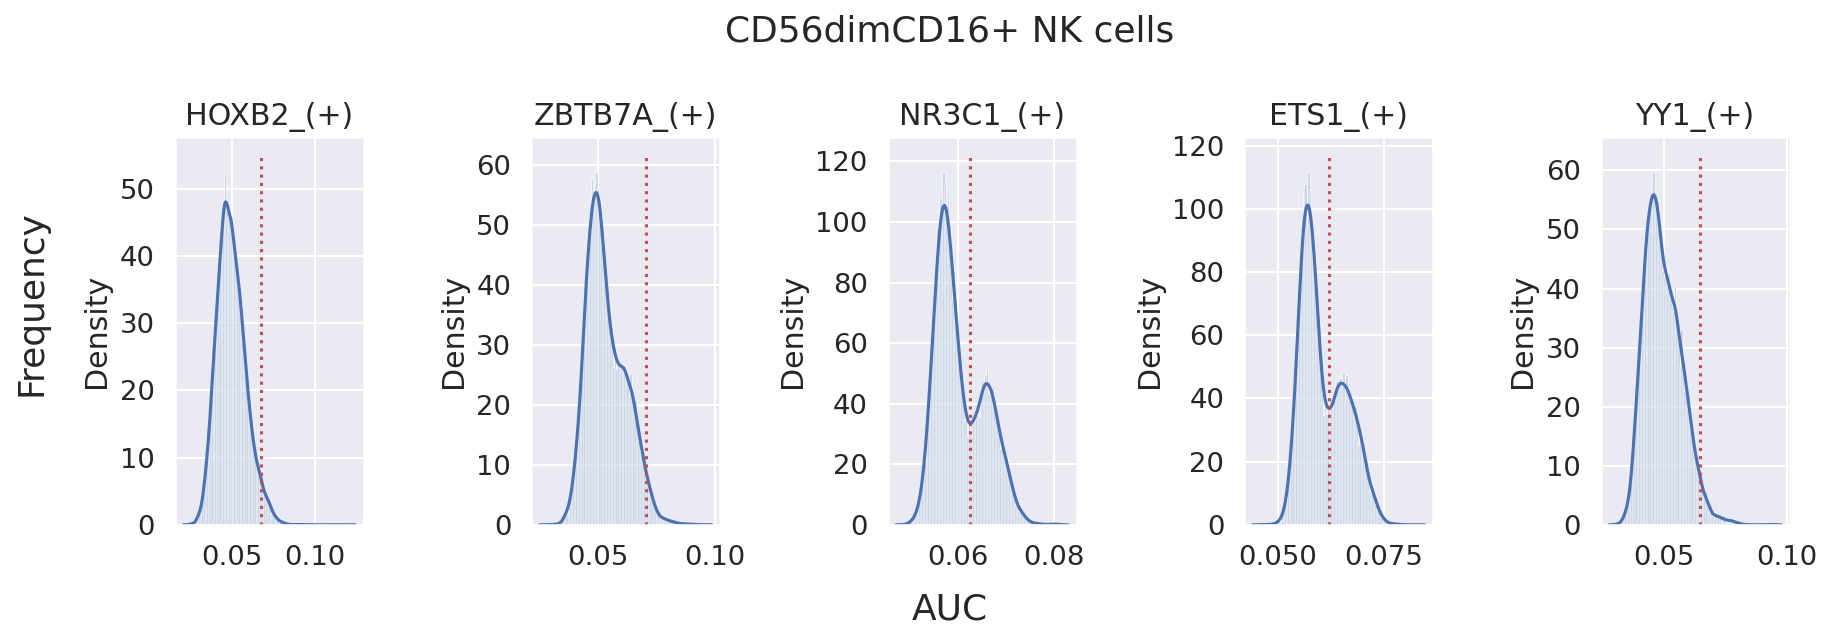

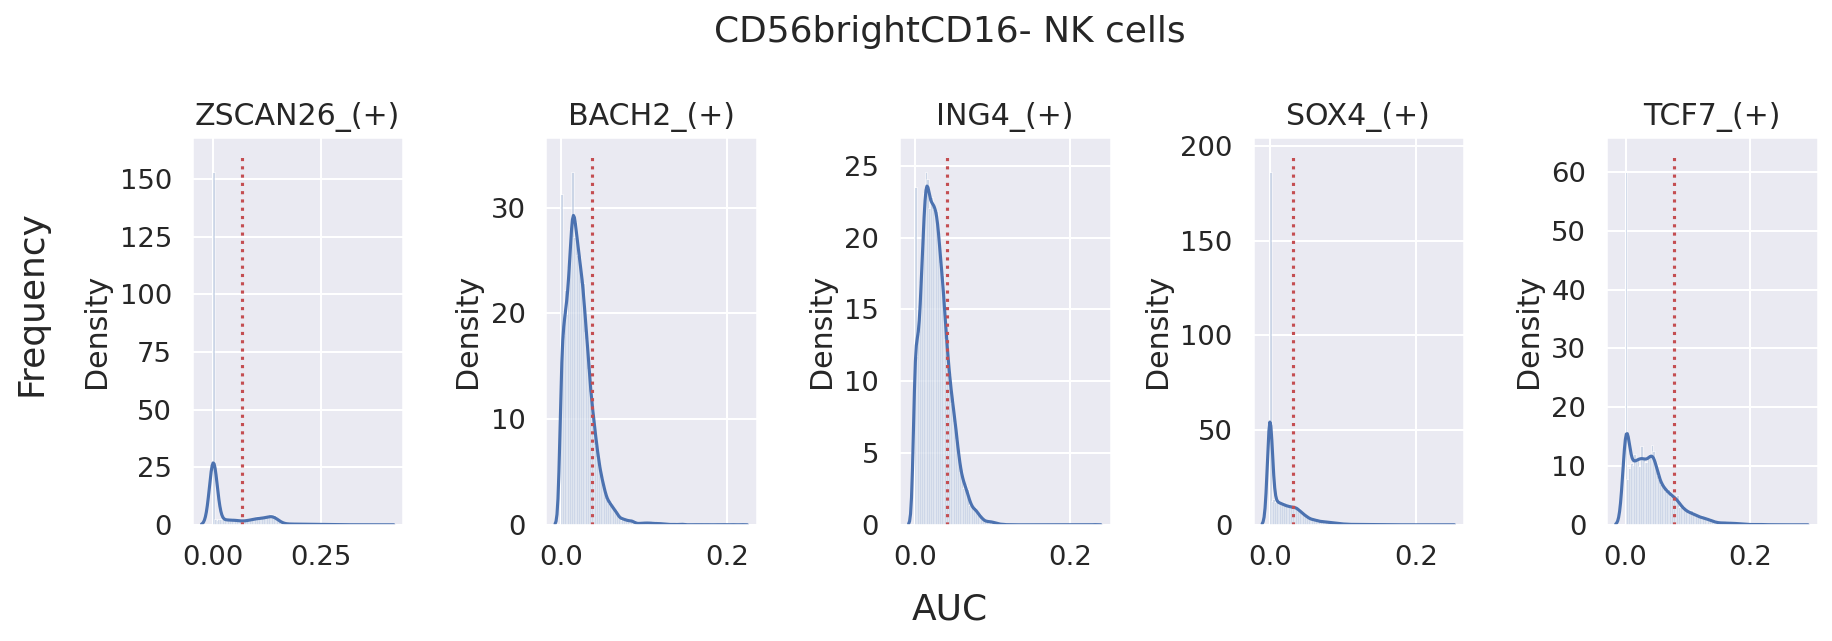

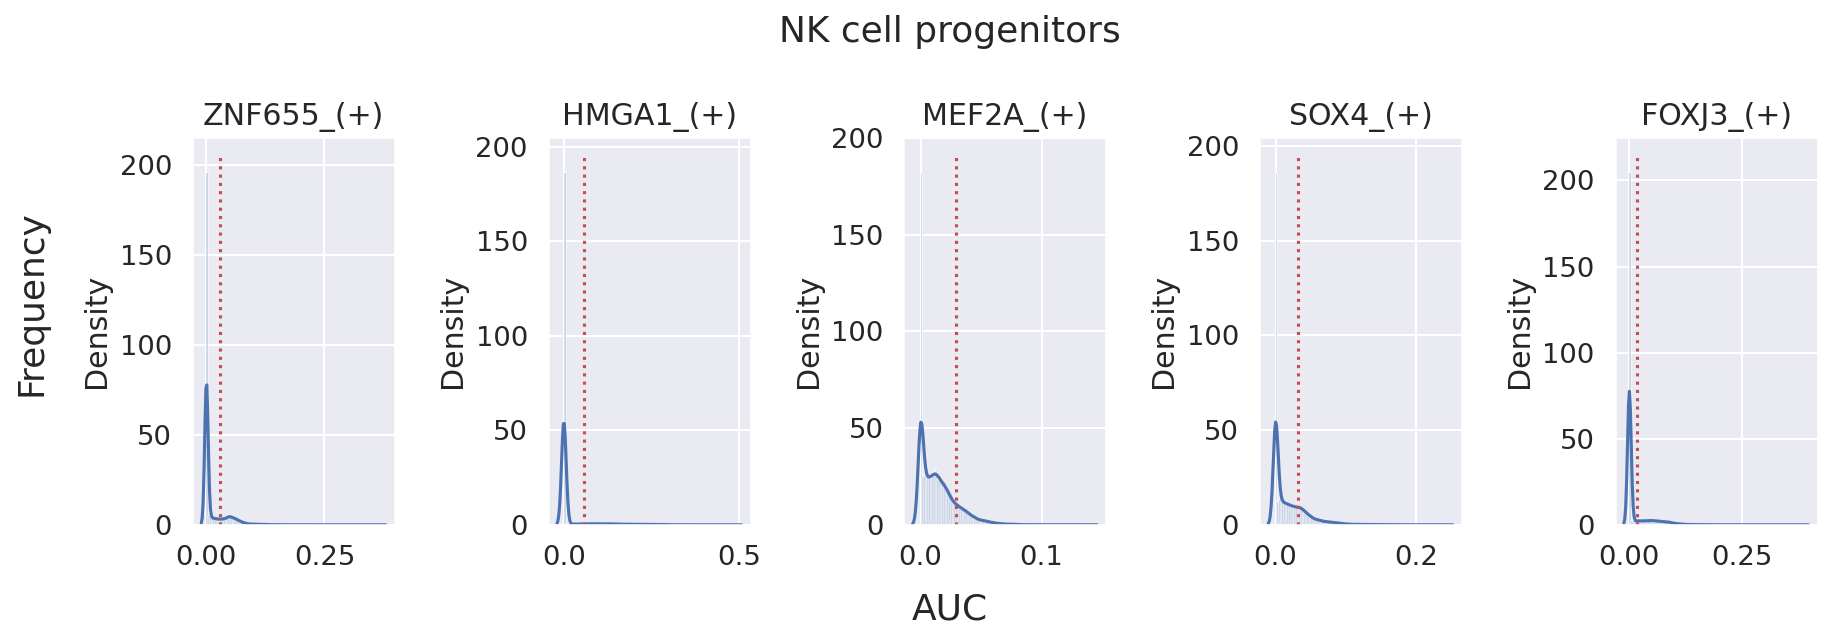

In [47]:
AUC_plot(rss_cellType)

In [48]:
export_regulons(rss_cellType, "Results/clusters_cell_types",10)


The specificity scores are quite different among the celltypes, CD56<sup>dim</sup> NK cells have the highest scores. The AUC looks better, especially for the NK CD56<sup>dim</sup> population

The specificity for the cell types looks odd, all the TF have a narrow range of specificity for each cell types, the scores resemble the different cell types ratios. Probably the RSS is biased by the big differences of proportions.



### TFs for cell states

#### Regulon specificity scores (RSS) across cell states

              ARID3A_(+)  ARNTL_(+)  ATF1_(+)  ATF2_(+)  ATF4_(+)  ATF6_(+)  \
NK exhausted    0.463639   0.458321  0.497775  0.465179  0.503545  0.377034   
Others          0.276448   0.270407  0.280775  0.275992  0.276288  0.253112   
NK resident     0.430142   0.455180  0.484617  0.452651  0.495673  0.426380   

              BACH1_(+)  BACH2_(+)  BCL11B_(+)  BCL6_(+)  ...  ZNF576_(+)  \
NK exhausted   0.498114   0.434075    0.513515  0.420506  ...    0.466683   
Others         0.278188   0.271988    0.279047  0.265811  ...    0.280341   
NK resident    0.497253   0.494404    0.480839  0.383245  ...    0.453640   

              ZNF580_(+)  ZNF587_(+)  ZNF600_(+)  ZNF655_(+)  ZNF669_(+)  \
NK exhausted    0.506104    0.281226    0.401912    0.314387    0.479456   
Others          0.281104    0.223671    0.265765    0.240490    0.281403   
NK resident     0.495097    0.292813    0.421775    0.315120    0.464933   

              ZNF680_(+)  ZNF708_(+)  ZNF770_(+)  ZSCAN26_(+)  
NK ex

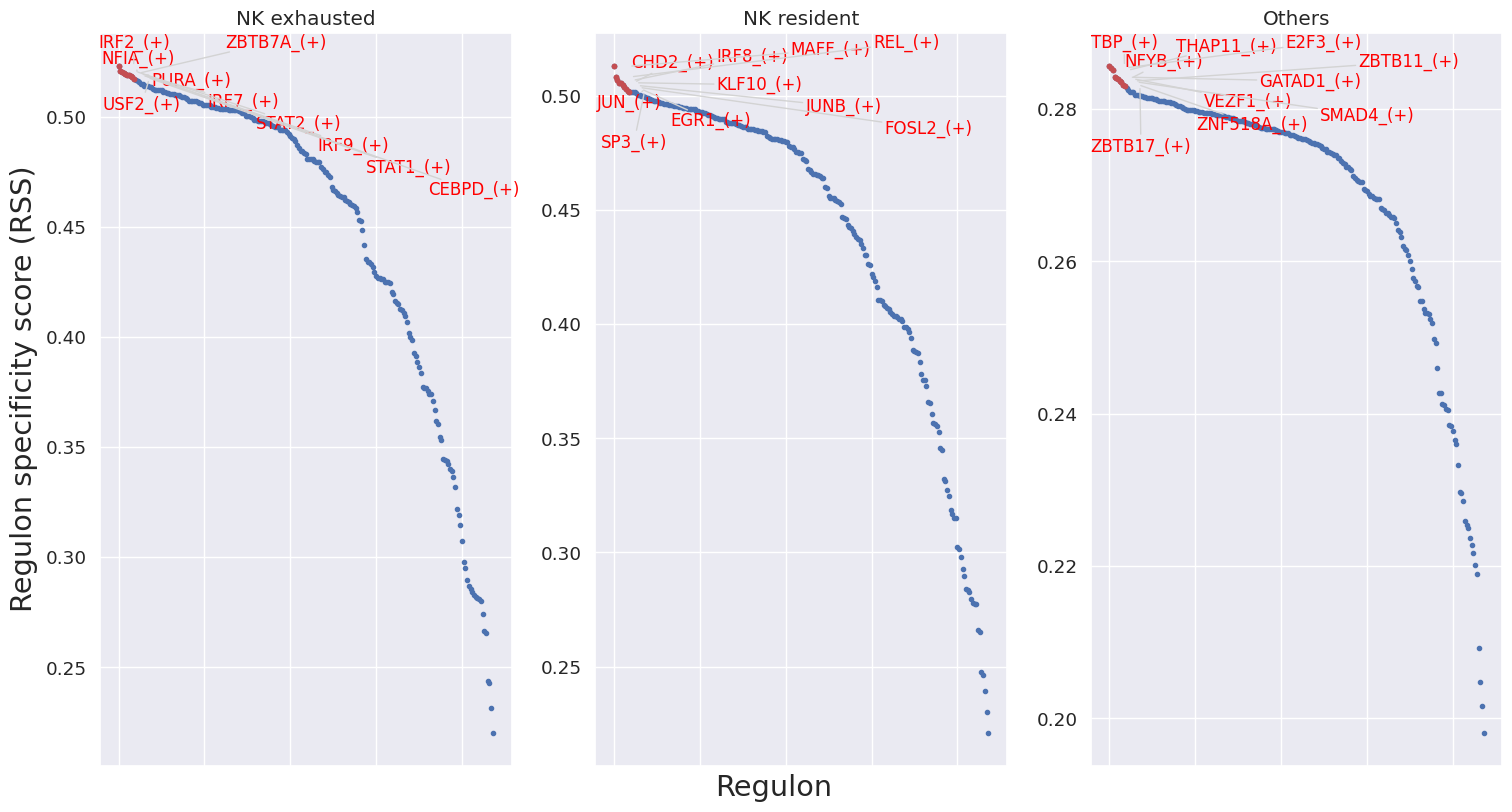

               mean  StDev  Ratio
NK exhausted  0.449  0.075  0.464
Others        0.269  0.018  0.105
NK resident   0.439  0.071  0.431


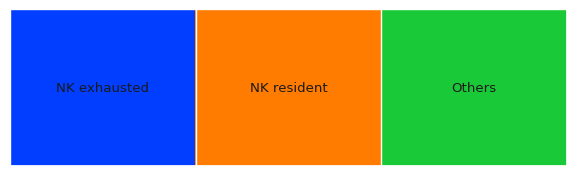

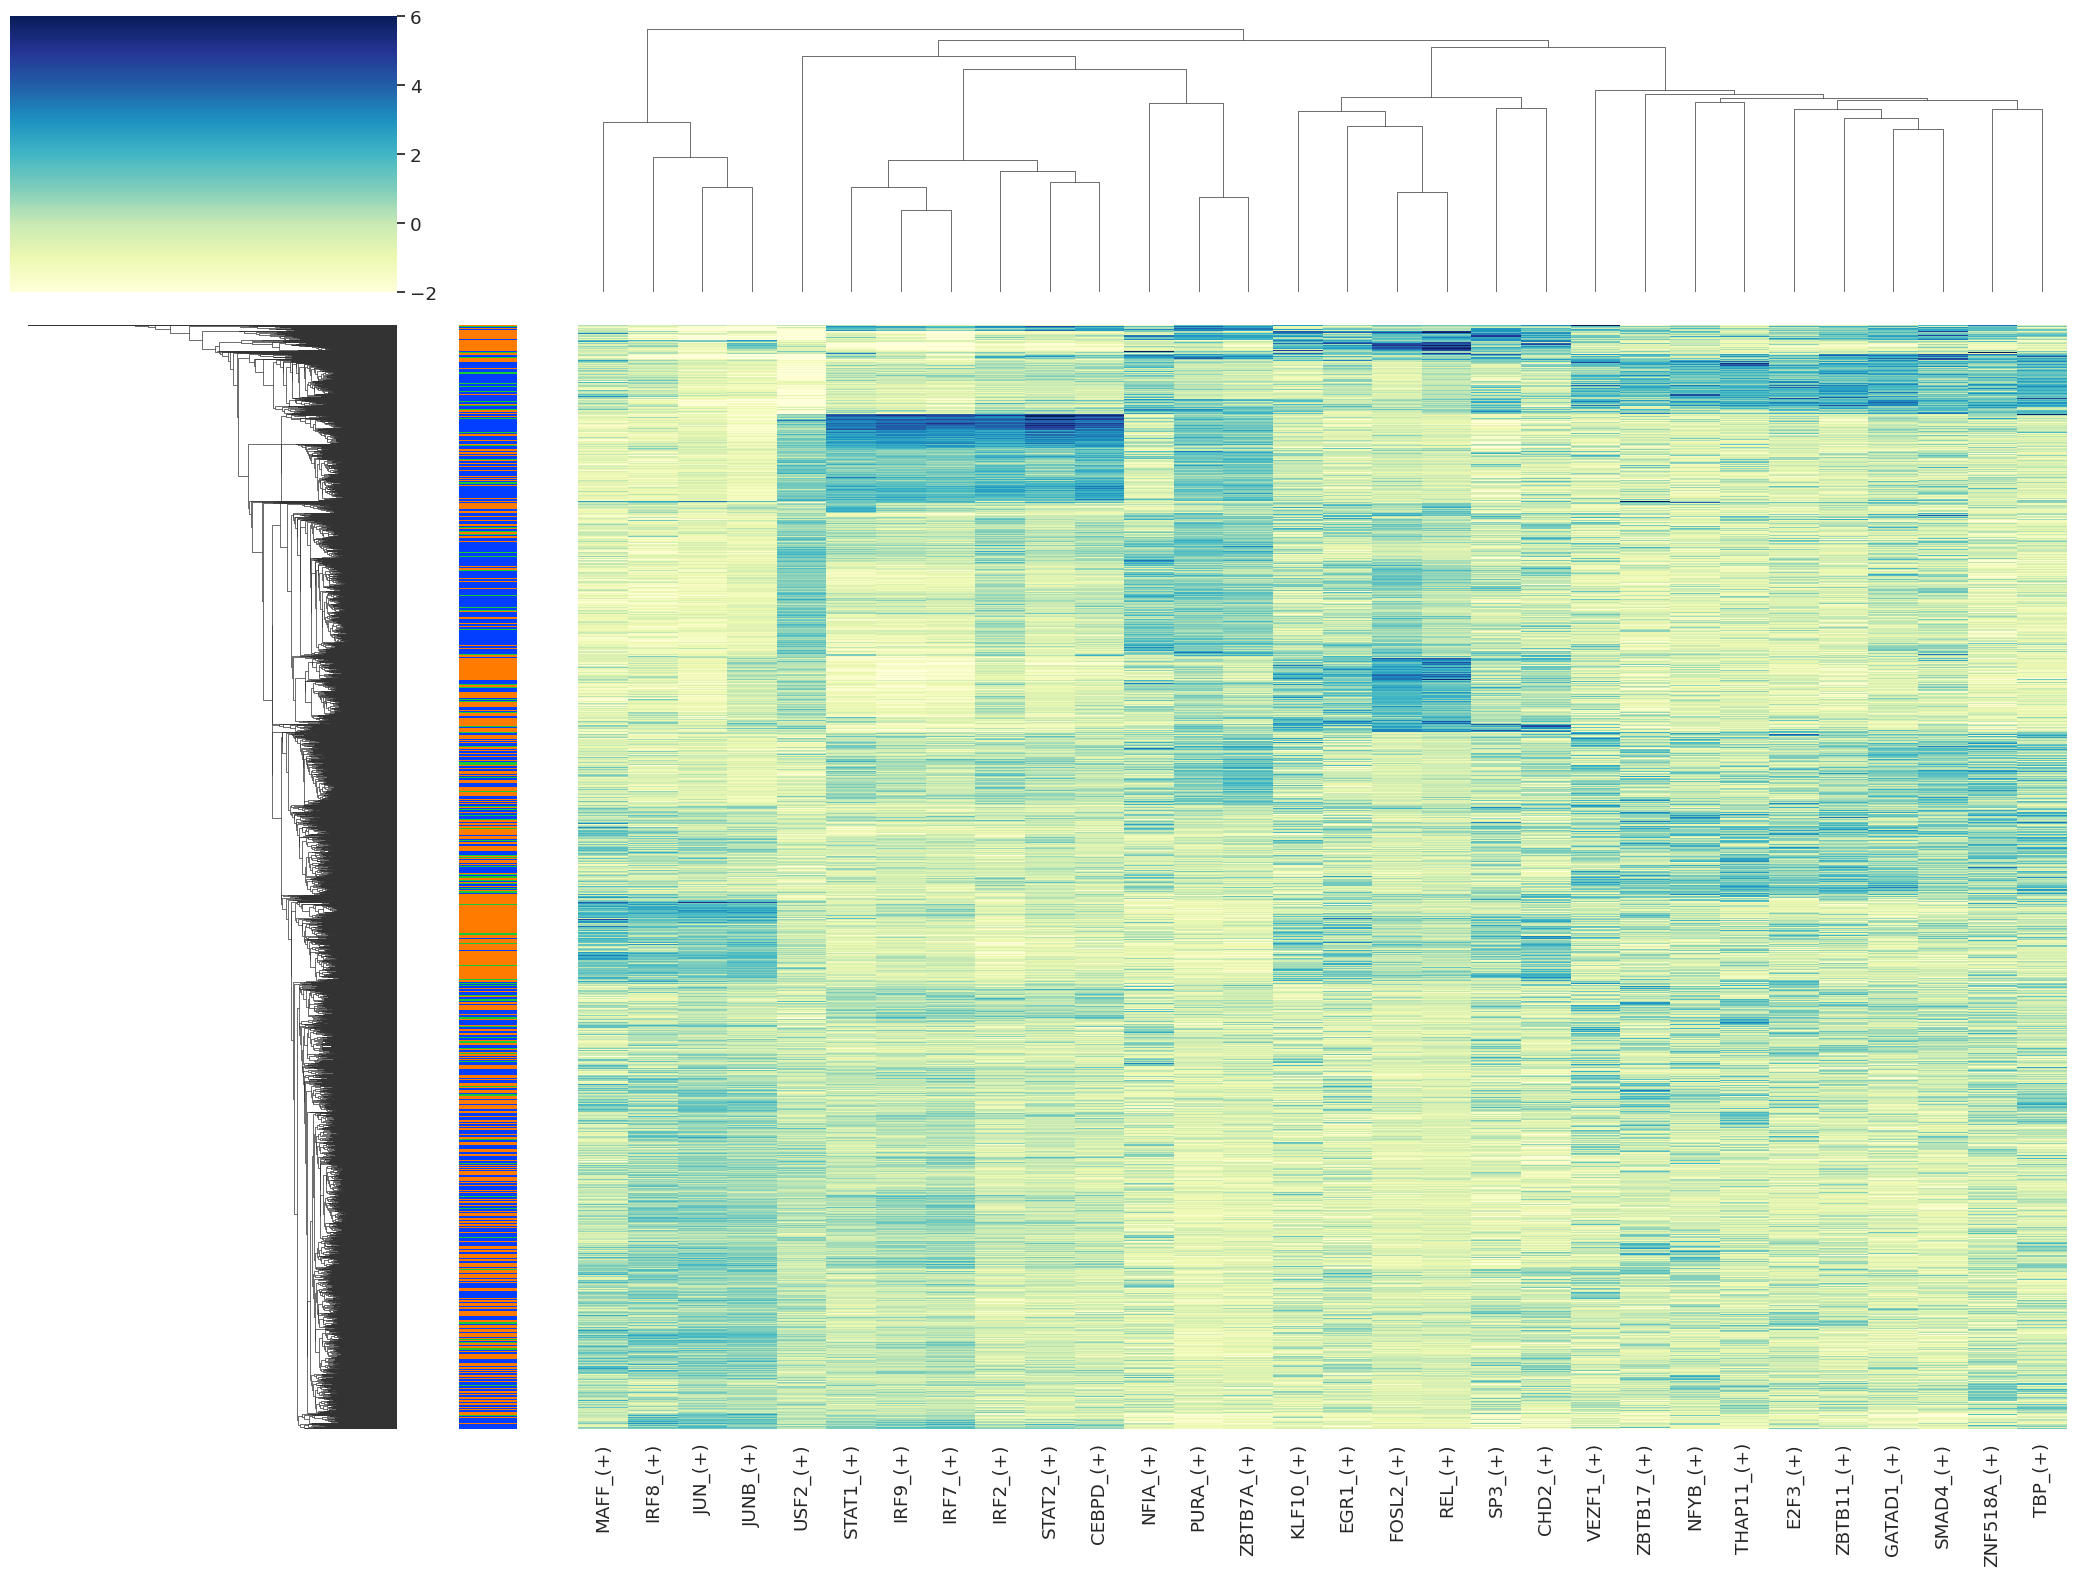

In [49]:
rss_cellType = TF_activity("new_label",10)

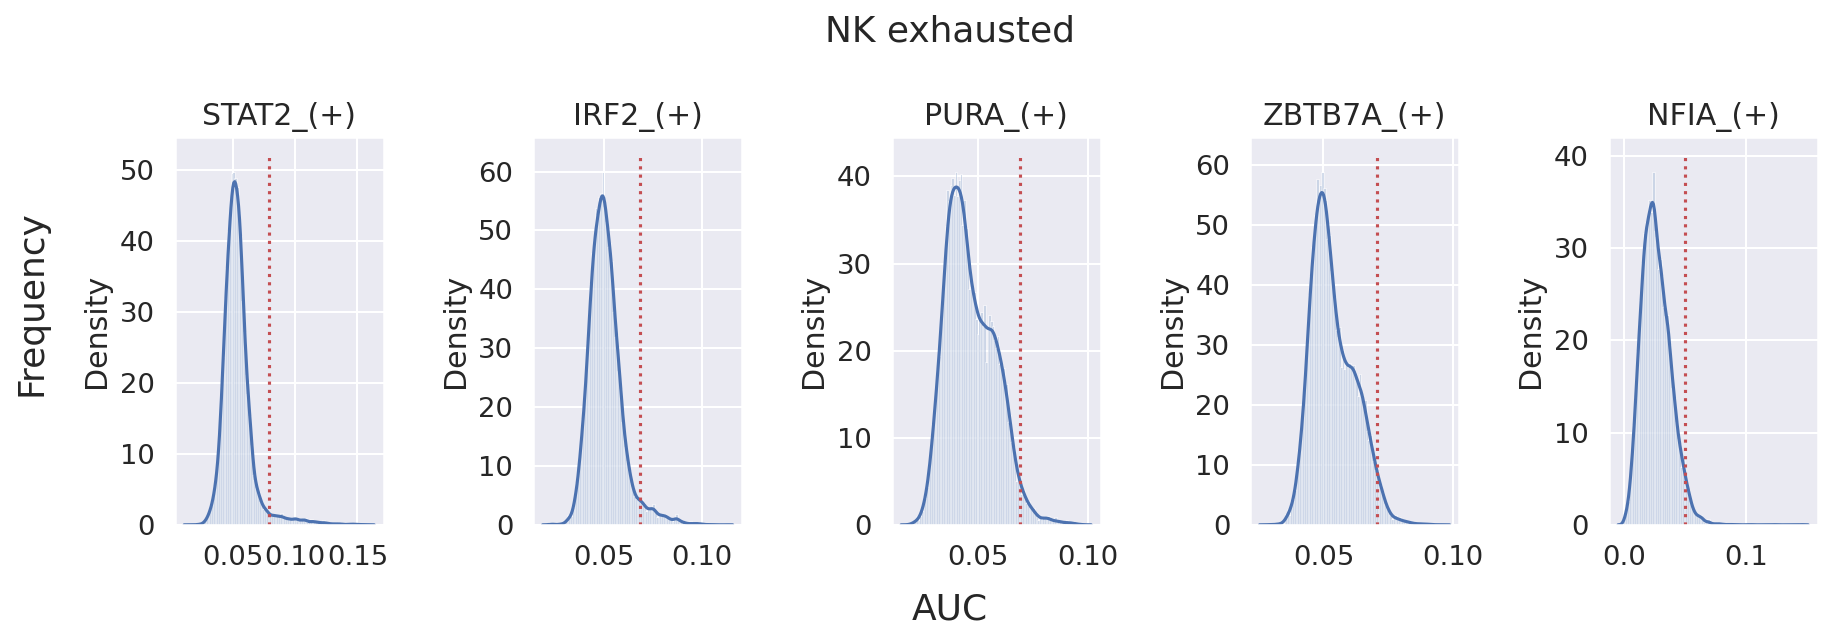

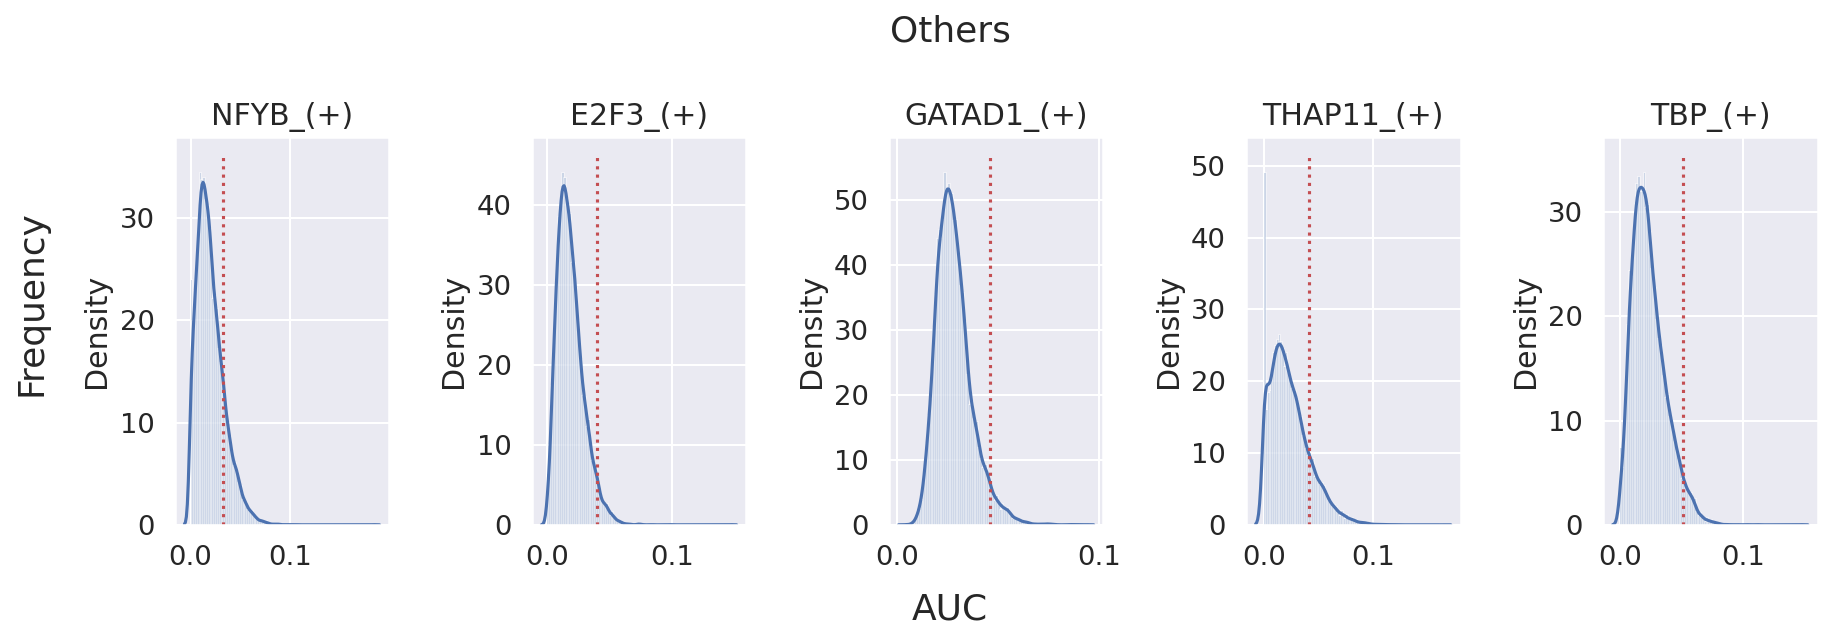

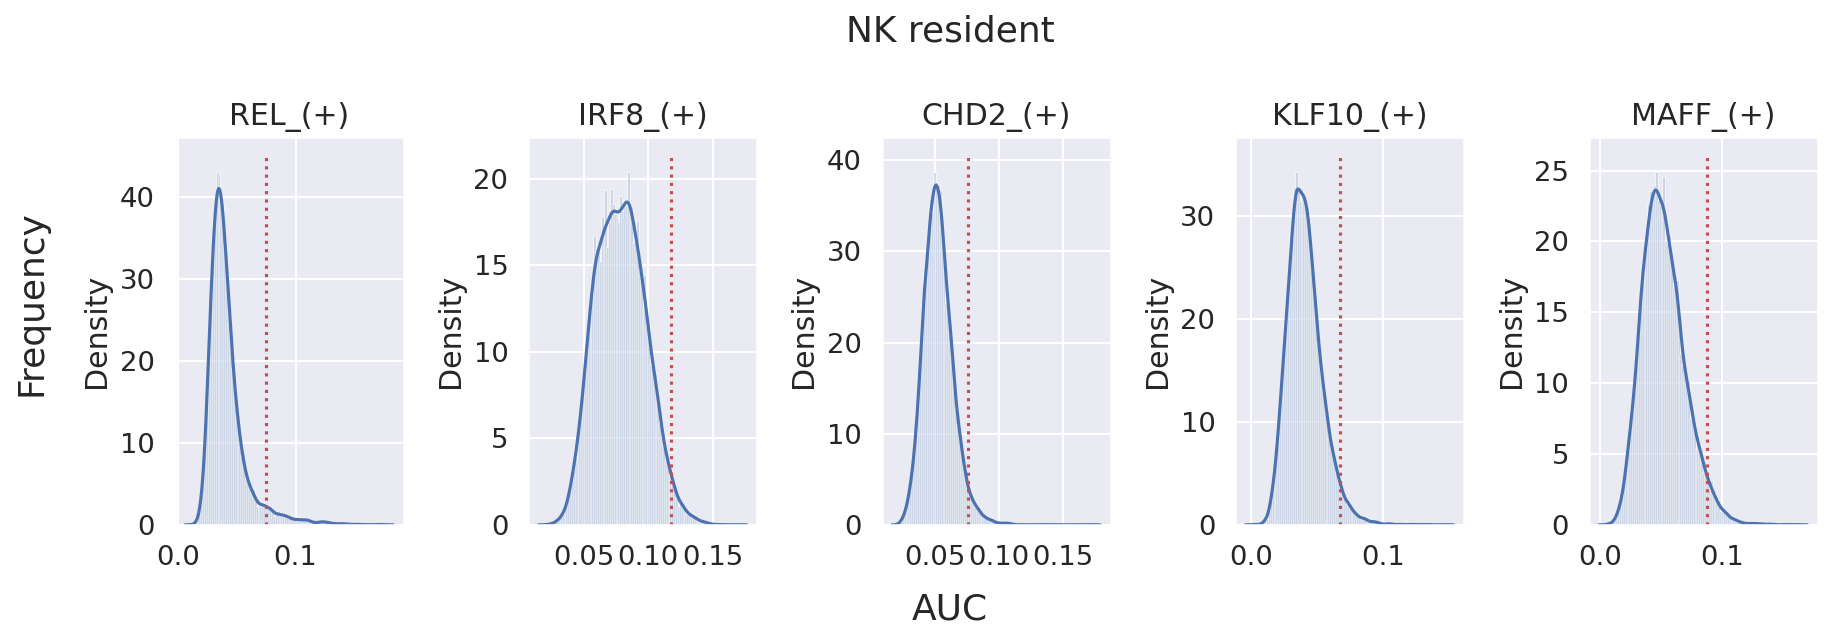

In [50]:
AUC_plot(rss_cellType)

In [51]:
export_regulons(rss_cellType, "Results/clusters_cell_states",10)


All the specificity scores reach a max value ~ 0.55 and their activity doesn't cluster the cells in the heatmap. Also, the AUC look quite low. The low values could also derive from the high number of batches in the dataset. Anyway some TFs are interesting (like STAT).

### extra, batches:

In [52]:
rss_cellType = regulon_specificity_scores( auc_mtx, cellAnnot["batch"] )
rss_cellType

ARID3A_(+)  ARNTL_(+)  ATF1_(+)  ATF2_(+)  ATF4_(+)  \
MGUS_CD138nCD45p_2    0.170896   0.169268  0.170189  0.170365  0.170055   
MGUS_CD138nCD45p_3    0.204317   0.192854  0.198196  0.194469  0.194977   
MGUS_CD138nCD45p_4    0.177391   0.173407  0.176083  0.175713  0.175022   
MGUS_CD138nCD45p_5    0.176882   0.173296  0.175030  0.174044  0.174607   
MGUS_CD138n_1         0.192502   0.185239  0.188397  0.189900  0.187138   
...                        ...        ...       ...       ...       ...   
SMM_CD138nCD45p_9     0.181477   0.177165  0.180174  0.181480  0.178789   
SMM_CD138n_3          0.171903   0.169728  0.170921  0.171797  0.170510   
SMM_CD138n_4          0.203920   0.188879  0.200221  0.199888  0.196458   
SMM_CD138n_5          0.172469   0.170303  0.172419  0.173040  0.171650   
SMM_CD138n_6          0.173069   0.172687  0.172206  0.172443  0.171678   

                    ATF6_(+)  BACH1_(+)  BACH2_(+)  BCL11B_(+)  BCL6_(+)  ...  \
MGUS_CD138nCD45p_2  0.170218   0.169829   0.170273    0.169811  0.171568  ...   
MGUS_CD138nCD45p_3  0.193858   0.194935   0.188656    0.192533  0.184365  ...   
MGUS_CD138nCD45p_4  0.174343   0.174629   0.174702    0.174425  0.171125  ...   
MGUS_CD138nCD45p_5  0.175083   0.174073   0.173334    0.173842  0.172365  ...   
MGUS_CD138n_1       0.189471   0.185122   0.184466    0.185889  0.182334  ...   
...                      ...        ...        ...         ...       ...  ...   
SMM_CD138nCD45p_9   0.178514   0.177638   0.177662    0.178149  0.179777  ...   
SMM_CD138n_3        0.169777   0.170556   0.170774    0.170349  0.170992  ...   
SMM_CD138n_4        0.190234   0.193584   0.195191    0.195148  0.193618  ...   
SMM_CD138n_5        0.170579   0.171879   0.172690    0.171502  0.172554  ...   
SMM_CD138n_6        0.171593   0.171539   0.171179    0.171610  0.172385  ...   

                    ZNF576_(+)  ZNF580_(+)  ZNF587_(+)  ZNF600_(+)  \
MGUS_CD138nCD45p_2    0.170911    0.170567    0.170461    0.170509   
MGUS_CD138nCD45p_3    0.198002    0.197983    0.189419    0.194885   
MGUS_CD138nCD45p_4    0.176208    0.175900    0.173372    0.175044   
MGUS_CD138nCD45p_5    0.175379    0.175268    0.175146    0.173380   
MGUS_CD138n_1         0.188824    0.189817    0.180835    0.181638   
...                        ...         ...         ...         ...   
SMM_CD138nCD45p_9     0.182603    0.180533    0.179998    0.177006   
SMM_CD138n_3          0.171229    0.170837    0.170803    0.170697   
SMM_CD138n_4          0.201070    0.198847    0.186835    0.194454   
SMM_CD138n_5          0.173245    0.172636    0.170128    0.171631   
SMM_CD138n_6          0.172766    0.172447    0.169355    0.171222   

                    ZNF655_(+)  ZNF669_(+)  ZNF680_(+)  ZNF708_(+)  \
MGUS_CD138nCD45p_2    0.169218    0.170486    0.175699    0.168928   
MGUS_CD138nCD45p_3    0.192884    0.198591    0.235459    0.173732   
MGUS_CD138nCD45p_4    0.175155    0.176817    0.185459    0.173322   
MGUS_CD138nCD45p_5    0.175684    0.175124    0.185886    0.169641   
MGUS_CD138n_1         0.182640    0.192862    0.213541    0.176922   
...                        ...         ...         ...         ...   
SMM_CD138nCD45p_9     0.175865    0.183166    0.198056    0.178603   
SMM_CD138n_3          0.169331    0.171389    0.173764    0.169179   
SMM_CD138n_4          0.192864    0.202913    0.238553    0.182198   
SMM_CD138n_5          0.171312    0.173533    0.179210    0.168251   
SMM_CD138n_6          0.170413    0.172914    0.178244    0.172118   

                    ZNF770_(+)  ZSCAN26_(+)  
MGUS_CD138nCD45p_2    0.167549     0.170142  
MGUS_CD138nCD45p_3    0.182398     0.187878  
MGUS_CD138nCD45p_4    0.169644     0.175739  
MGUS_CD138nCD45p_5    0.170601     0.173757  
MGUS_CD138n_1         0.182610     0.183272  
...                        ...          ...  
SMM_CD138nCD45p_9     0.176606     0.182598  
SMM_CD138n_3          0.170918     0.169807  
SMM_CD138n_4          0.184110     0.188803  
SMM_

In [53]:
means = round(rss_cellType.T.mean(),3)
means = means.rename("mean")
sd = round(rss_cellType.T.std(),3)
sd = sd.rename("StDev")
ratio = round(adata.obs["batch"].value_counts()/adata.n_obs,3)
ratio = ratio.rename("Ratio")
specs = pd.concat([means,sd,ratio],axis=1)
specs

mean  StDev  Ratio
MGUS_CD138nCD45p_2  0.170  0.001  0.001
MGUS_CD138nCD45p_3  0.195  0.007  0.018
MGUS_CD138nCD45p_4  0.175  0.002  0.004
MGUS_CD138nCD45p_5  0.175  0.002  0.004
MGUS_CD138n_1       0.187  0.005  0.013
...                   ...    ...    ...
SMM_CD138nCD45p_9   0.180  0.004  0.006
SMM_CD138n_3        0.171  0.001  0.001
SMM_CD138n_4        0.197  0.008  0.019
SMM_CD138n_5        0.172  0.001  0.002
SMM_CD138n_6        0.172  0.001  0.002

[76 rows x 3 columns]

In [54]:
specs.describe()

mean      StDev      Ratio
count  76.000000  76.000000  76.000000
mean    0.184039   0.004618   0.013158
std     0.021651   0.006751   0.023457
min     0.168000   0.000000   0.000000
25%     0.171750   0.001000   0.002000
50%     0.176000   0.002000   0.005500
75%     0.187500   0.006000   0.013250
max     0.285000   0.040000   0.145000